In [1]:

import os
import subprocess as sbp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn


from scipy.stats import ttest_rel  
import scipy.stats as sta
import matplotlib.cm as cm
import matplotlib as mpl
#import matplotlib.pyplot as plt


##plots tipo slider 
import plotly.graph_objects as go


from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


import scipy.signal as ssi
import statsmodels as smo
from scipy.fft import fft, fftfreq

from keras.utils import np_utils

import random

In [2]:
#### file splitter, div entre test/val/train
def file_splitter_train_test_val(fullsetfile,spltDct={"val":20.0, "test":10.0}):
    ### permite dividir en test/train o test/val/train
    nontrain=0.0
    for key,val in spltDct.items():
        nontrain+=val
    #spltDct["train"]=100.0-nontrain
    
    #fullset=pd.read_csv(fullsetfile)
    fullset=np.loadtxt(fullsetfile ,delimiter=";")
    ## shuffle
    rng=np.random.default_rng()
    rng.shuffle(fullset,axis=0)
    nline,ncols=np.shape(fullset)
    print("Balance en origen: ",np.sum(fullset[:,-1]))
    print("nline,ncols",nline,ncols)
    #ifull=np.arange(nline)
    #random.shuffle(ifull)
    
    #FileDct={}
    nsub=0
    n0=0
    for key,val in spltDct.items():
        nsub+=int(val/100.0*nline)
        print("n0,nsub",n0,nsub)
        subset=fullset[n0:nsub,:]
        n0=nsub
        print("Balance subset: ",np.sum(subset[:,-1])/np.shape(subset)[0] )
        np.savetxt(key+"_"+fullsetfile,subset,delimiter=",",fmt="%f")
        #FileDct[key]=key+fullsetfile
        #fwrite=open(file=key+fullsetfile,"w")
    subset=fullset[nsub:,:]
    print("remanente:", np.shape(subset))
    print("Balance rem: ",np.sum(subset[:,-1])/np.shape(subset)[0] )
    np.savetxt("train"+"_"+fullsetfile,subset,delimiter=",")
    

#file_splitter_train_test_val("ecg.csv")


In [3]:
### Por ahora creamos los features

class featured_tseries_df():
    ### se levanta el set full, con sus labels
    
    
    def __init__(self,filename,downsample=1,timeft=True,freqft=True,\
                 renormMx=100.0,renormMn=0.0,augment=None,diff=0,renormRowsDct=None,selfRenorm=False):
        
        self.filename=filename
        self.tab0=np.loadtxt(self.filename,delimiter=",")
        self.df0=self.tab0[:,:-1].astype("float64")
        self.labeltab=np_utils.to_categorical( self.tab0[:,-1]).astype("int") #.astype("float64")  #)## para keras
        self.labelvec=self.tab0[:,-1].astype(int)
        self.timeft=timeft
        self.freqft=freqft
        self.downsample=downsample
        
        #self.nrow,self.nt=np.shape(self.df0)
        
        self.renorm_01(renormMx,renormMn)
        #self.df0=self.df0
        #self.take_exp()
        #self.renorm_01(np.amax(self.df0) ,0.0)
    
        #self.renorm_01(renormMx,renormMn)
        #self.take_log10(0.0001)
        if selfRenorm==True:
            self.sigmas=np.std( self.df0 ,axis=0)
            self.sigma=np.mean(self.sigmas)
            self.means=np.mean(self.df0,axis=0)
            self.mean=np.mean(self.means)
            self.df0=self.df0-self.mean###self.means[np.newaxis,:]
            self.df0=self.df0/self.sigma
        if isinstance(renormRowsDct,dict):
            #self.sigmas=np.std( self.df0 ,axis=0)
            #self.sigma=np.std(self)
            #self.means=np.mean(self.df0,axis=0)
            self.df0=self.df0-renormRowsDct["mean"]###self.means[np.newaxis,:]
            self.df0=self.df0/renormRowsDct["std"]
            #self.df0=self.df0-self.sigma[np.newaxis,:]
        
        if augment is not None:
            self.data_augmentation(augment,dct={"roll":7})
        
        
        self.df_downsample()
        
        self.nrows0,self.ncols0=np.shape(self.df0)
        self.nrows1,self.ncols1=np.shape(self.df1)
        
        print("Pre downsample :", np.shape(self.df0))
        print("Post downsample :", np.shape(self.df1))
        
        if diff!=0:
            for idiff in np.arange(1,diff):
                self.df1=np.gradient( self.df1, axis=0)
        
        IDs=np.random.randint(0,high=self.nrows0,size=5)
        self.plot_random_signals(self.df0,IDs,title="Pre downsample",plotfilename="ECGrandom.png" )
        self.plot_random_signals(self.df1,IDs,title="Post downsample",plotfilename="ECGrandomDSP.png" )
        self.plot_boxplots()
        self.df2=pd.DataFrame()
        
        if self.timeft==True:
            self.generate_timeft()
        if self.freqft==True:
            self.Fdf0=np.fft.fft(self.df0,axis=1)[:,0:self.ncols0//2]
            self.generate_freqft()
        if self.timeft or self.freqft:
            self.df2["labelvec"]=self.labelvec
            self.df2Cols=list(self.df2.columns)
        #self.plot_random_signals(self.df0,IDs,title="Pre downsample",plotfilename="SpO2random.png" )
            self.plot_random_signals(self.FAbsdf0,IDs,title="FFT Post downsample",plotfilename="FFTecgrandomDSP.png",yscale=[0.0,10.0] )
            print("NANs:",self.df2.isna().sum().sum() )
            for col in self.df2Cols:
                print("NANs ["+col+"]:",self.df2[col].isna().sum() )
        self.df1=self.df1[:,:,np.newaxis]
        
        
    def data_augmentation(self,naug,dct):
        
        if "roll" in dct.keys():
            step0=dct["roll"]
            dfaux0=np.roll(self.df0,0,axis=0)
            lab0=self.labeltab
            vec0=self.labelvec
            for iaug in np.arange(naug):
                dfaux=np.roll(self.df0,step0*(iaug+1),axis=0)
                dfaux0=np.concatenate( (dfaux0,dfaux), axis=0)
                
                lab0=np.concatenate( (lab0,self.labeltab),axis=0)
                vec0=np.concatenate(  (vec0,self.labelvec),axis=0)
                
            self.df0=dfaux0 #np.concatenate( (self.df0,dfaux0), axis=0)
            self.labeltab=lab0    
            self.labelvec=vec0
    
    def generate_timeft(self):
        myax=1
        #### lost area 
        #netarea=np.sum(self.df1,axis=myax)
        totarea=np.sum( np.abs(self.df1),axis=myax)/np.sum( np.ones_like(self.df1[0,:]) )
        self.df2["totarea"]=totarea #netarea/totarea
        #### first derivative 
        self.df1D=np.gradient( self.df1, axis=myax)
        firstder=np.sum (  np.abs(self.df1D  ) ,axis=myax)
        self.df2["first_der"]=firstder / np.sum( np.ones_like(self.df1[0,:]) )  #totarea
        #### secder
        self.df1D2=np.gradient( self.df1D, axis=myax)
        secder=np.sum (  np.abs( self.df1D2 ) ,axis=myax)
        
        #self.df2["sec_der"]=secder /totarea
        ### amplitude 
        self.df2["amplitude"]=np.max(self.df1,axis=myax)-np.min(self.df1,axis=myax)
        
        print("NROWS in DF2",len(self.df2) )
    def generate_freqft(self):
        myax=1
        #freq = np.fft.fftfreq(tvec.shape[-1])##*2.0*np.pi/ht/omegaIR_au
        FouD1=np.fft.fft(self.df1D,axis=myax)[:,0:self.ncols1//2]
        self.FAbsdf0=np.abs(FouD1)**2 #np.fft.fft(self.df0,axis=0)
        self.FPhasdf0=np.angle(FouD1) ### son arrays 1D por cada entrada.
        self.df2["fou_maxamp"]=np.log( np.amax(self.FAbsdf0,axis=myax)/np.average(self.FAbsdf0,axis=myax) )
        self.df2["fou_freqmax"]=np.argmax(self.FAbsdf0,axis=myax).astype("float64")/np.shape(self.FAbsdf0)[1]
        
    def df_downsample(self,imethod=1):
        if self.downsample==1:
            pass
            self.df1=self.df0
        else :
            if imethod==0:
                self.df0=self.df0[:,0::self.downsample]
            elif imethod == 1 : ### genera un suavizado
                nrow,ncol=np.shape(self.df0)
                ndown=ncol//self.downsample
                self.df1=np.zeros( (nrow,ndown),dtype=float)
                
                #aux1=np.zeros()
                for idown in np.arange(self.downsample):
                    self.df1+=self.df0[:,idown::self.downsample] ### sumamos los desplazados
                self.df1/=self.downsample  ### div por el nro de subsampling
                    
    def renorm_01(self,mx,mn): ### renorm the SpO2 signal to [0,1], no centering.
        #pass
        self.df0/=(mx-mn)
        
    def take_log10(self,eps):
        self.df0=np.log10(eps+self.df0)
    def take_exp(self):
        self.df0=np.exp(self.df0)

        
    ####smo.tsa.stattools.acf()
    def plot_random_signals(self,mydf,IDs,title=" ",plotfilename=" ",yscale=[0.75,1.0]):

        nplot=len(IDs)
        linestyle_str = ["-",":","--","-."]
        linewidth=[4]
        linecol=["b","g","r","c","m","y","tab:orange","tab:blue","tab:purple","tab:grey"]
        nwidths=len(linewidth)
        nstyles=len(linestyle_str)
        ncolor=len(linecol)
        
        
        fig = plt.figure(figsize=(15.0, 5.0), dpi=80)
        fig.set_frameon(False)

        fig.suptitle(title)
        ax1 = fig.add_subplot(111)
        ax4=fig.add_subplot(111) 
        #ax1.set_ylim(yscale[0],yscale[1])
        #ax1.set_ylim(yscale[0],yscale[1])

        ax1.set_xlabel('$i_t$ ', fontsize = 35)
        ax1.set_ylabel('ecg signal', fontsize = 35)
        ax4.set_xlabel('$i_t$ ', fontsize = 35)
        ax4.set_ylabel('ecg signal', fontsize = 35)        #ax2 = ax1.twiny()

        ax1.tick_params("both",labelsize=24)

        for iplt in IDs:
            ax1.plot(mydf[iplt,:],lw=linewidth[iplt%nwidths],linestyle=linestyle_str[iplt%nstyles],\
                     color=linecol[iplt%ncolor])#,marker="X",ms=12,label="Retrieved")
        #plt.tricontourf(spec[:,0],spec[:,1],spec[:,2], 50,cmap=cmpalette)

        if plotfilename !=" ":
            plt.savefig(plotfilename,bbox_inches='tight', transparent=False)
        
    def plot_boxplots(self):
        print("Balanced?")
        print(np.sum(self.labelvec)/np.shape(self.labelvec)[0])
        print( np.sum(self.labeltab,axis=0 ) )
        for col in self.df1:
            #DBbox=[]#{}#[]
            #for ilev, lev in enumerate(Levs):
            #    DBbox.append( DBNum[col].loc[DBTarg[TargVar]==lev])
            #    #DBbox[ilev]= DBNum[col].loc[DBTarg[TargVar]==lev]
            pass

        



Pre downsample : (9996, 140)
Post downsample : (9996, 140)


<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be cr

Balanced?
0.5840336134453782
[4158 5838]
NROWS in DF2 9996
NANs: 0
NANs [totarea]: 0
NANs [first_der]: 0
NANs [amplitude]: 0
NANs [fou_maxamp]: 0
NANs [fou_freqmax]: 0
NANs [labelvec]: 0


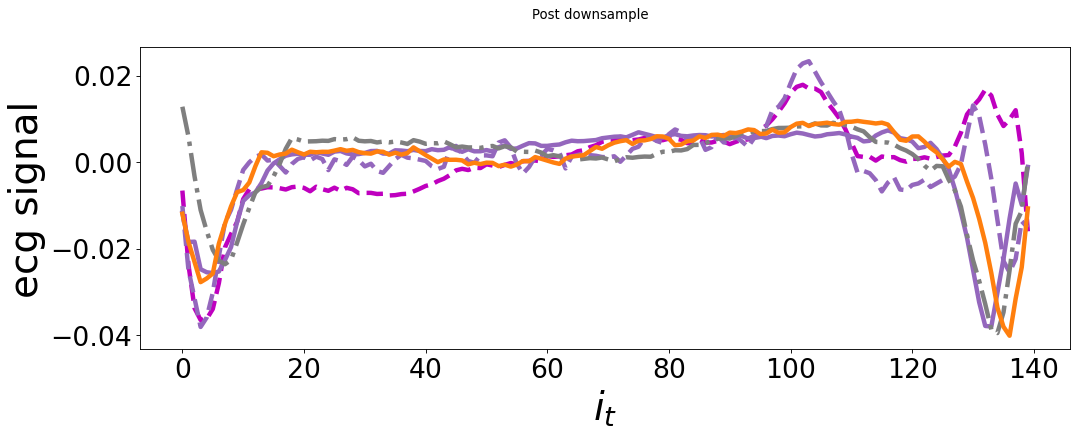

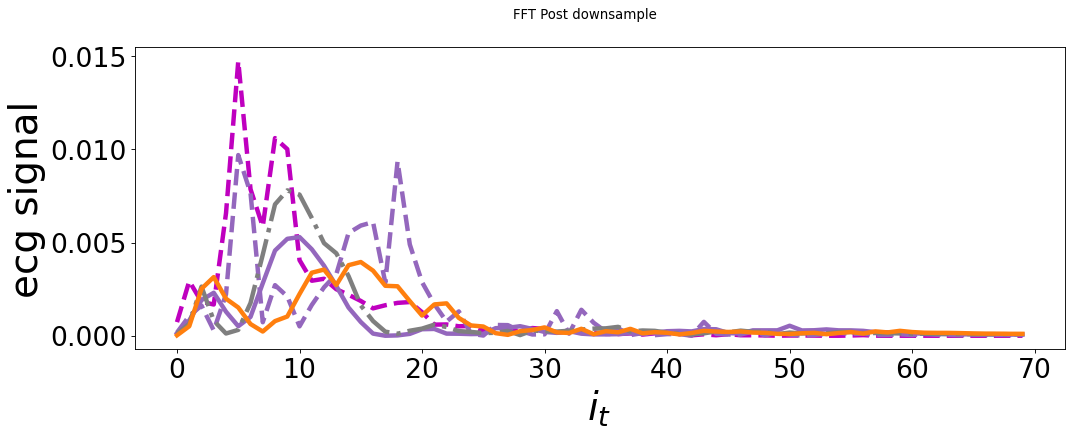

In [4]:
TSfull=featured_tseries_df("../DatosOriginales/ecg.csv",downsample=1,timeft=True,freqft=True,\
                     renormMx=100.0,renormMn=0.0,augment=1,diff=0,\
                    renormRowsDct=None,selfRenorm=False) 


In [5]:
TSfull.df2.info()
TSfull.df2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9996 entries, 0 to 9995
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   totarea      9996 non-null   float64
 1   first_der    9996 non-null   float64
 2   amplitude    9996 non-null   float64
 3   fou_maxamp   9996 non-null   float64
 4   fou_freqmax  9996 non-null   float64
 5   labelvec     9996 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 468.7 KB


totarea    first_der    amplitude   fou_maxamp  fou_freqmax  \
count  9996.000000  9996.000000  9996.000000  9996.000000  9996.000000   
mean      0.006673     0.001393     0.057990     2.012541     0.105202   
std       0.000465     0.000303     0.008246     0.279839     0.054037   
min       0.004563     0.000341     0.026377     0.742379     0.000000   
25%       0.006416     0.001193     0.050637     1.839033     0.071429   
50%       0.006667     0.001381     0.060388     2.041990     0.071429   
75%       0.006915     0.001557     0.064147     2.207395     0.142857   
max       0.009545     0.005653     0.112176     2.941439     0.700000   

          labelvec  
count  9996.000000  
mean      0.584034  
std       0.492912  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000

Index(['totarea', 'first_der', 'amplitude', 'fou_maxamp', 'fou_freqmax',
       'labelvec'],
      dtype='object')
    totarea  first_der  amplitude  fou_maxamp  fou_freqmax
0  0.006581   0.001440   0.065014    1.912766     0.128571
1  0.006062   0.001654   0.066709    2.029855     0.071429
2  0.006718   0.001798   0.068471    1.976054     0.071429
3  0.006609   0.001557   0.063196    2.109838     0.071429
4  0.007202   0.001429   0.060799    1.998860     0.071429
           totarea    first_der    amplitude   fou_maxamp  fou_freqmax
count  9996.000000  9996.000000  9996.000000  9996.000000  9996.000000
mean      0.006673     0.001393     0.057990     2.012541     0.105202
std       0.000465     0.000303     0.008246     0.279839     0.054037
min       0.004563     0.000341     0.026377     0.742379     0.000000
25%       0.006416     0.001193     0.050637     1.839033     0.071429
50%       0.006667     0.001381     0.060388     2.041990     0.071429
75%       0.006915     0.001557   

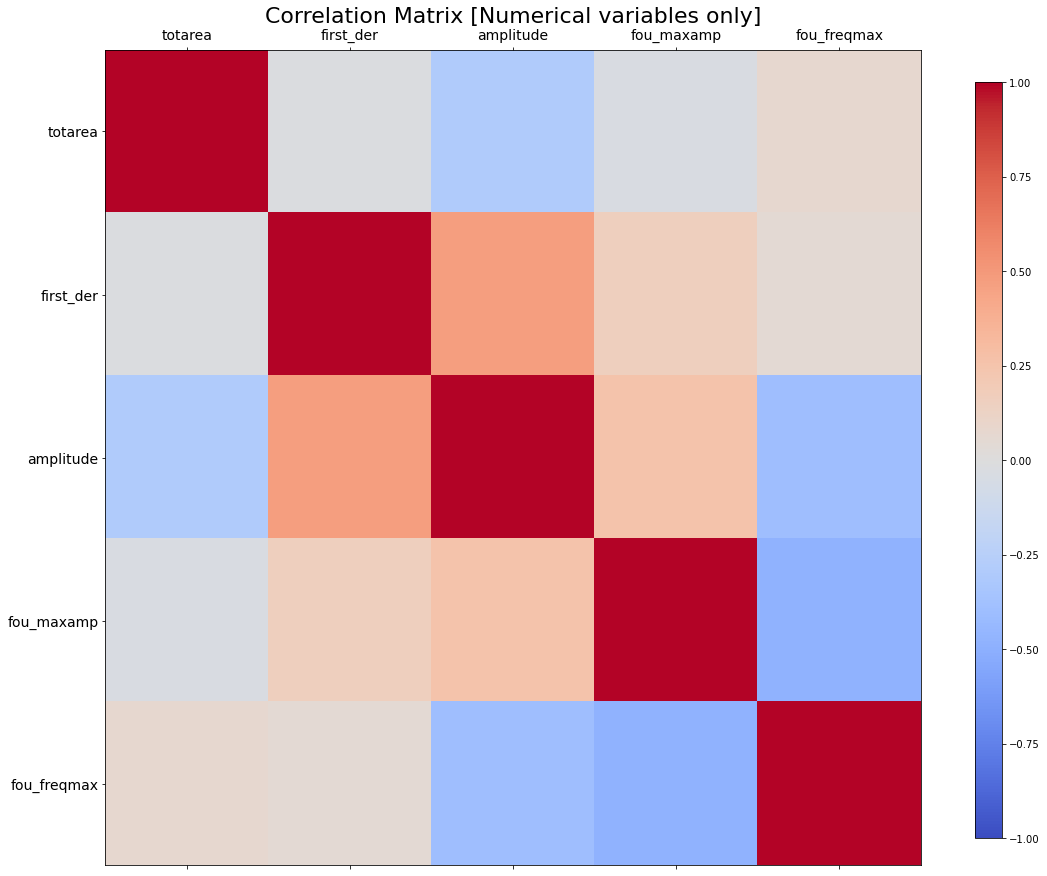

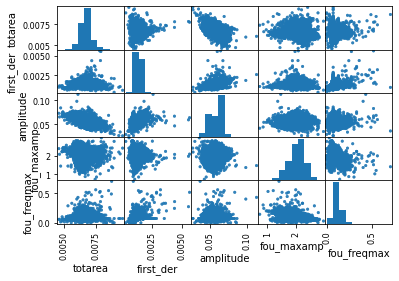

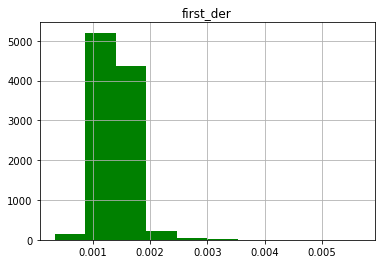

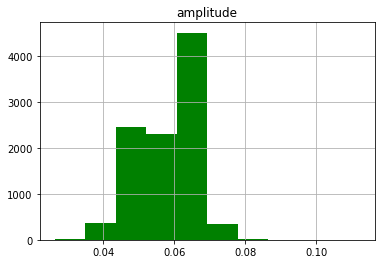

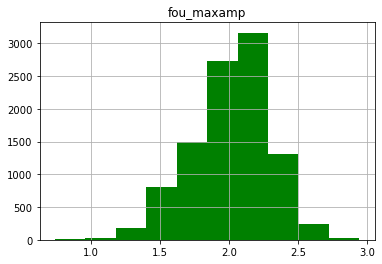

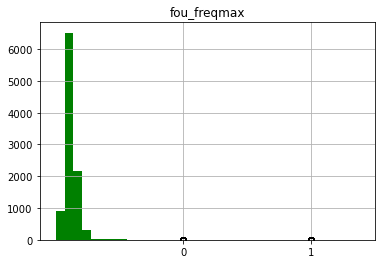

first_der


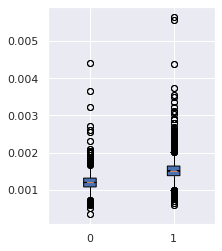

amplitude


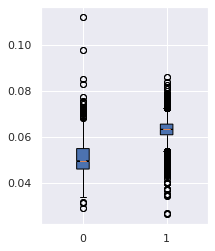

fou_maxamp


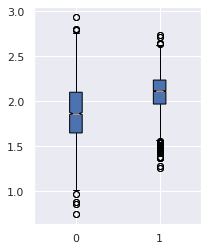

fou_freqmax


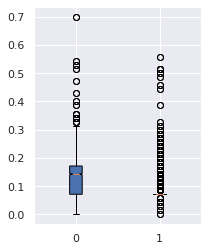

In [6]:
#!/usr/bin/env python
# coding: utf-8

import os
import subprocess as sbp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


from scipy.stats import ttest_rel  
import scipy.stats as sta
import matplotlib.cm as cm
import matplotlib as mpl
#import matplotlib.pyplot as plt


##plots tipo slider 
import plotly.graph_objects as go


from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler




DB000=TSfull.df2
ConvertAllToCat=False
DB000.dropna(axis=0,inplace=True)
DB000.reset_index(drop=True,inplace=True)
TargVar="labelvec"

cols0=DB000.columns
DBTarg=DB000[TargVar].to_frame(name=TargVar).astype("category")
DB000=DB000.loc[:,~DB000.columns.isin([TargVar])]
print(cols0)
#ColDct={}
ColLs=[]
ColLsNoTarg=[]
for il,l in enumerate(cols0):
    #ColDct[cols0[il]]=l
    ColLs.append(l)
    if l != TargVar:
        ColLsNoTarg.append(l)
#print(ColLsNoTarg)
#print(ColLs)


if ConvertAllToCat==True:
    for col in ColLs:
    #pass
        DB000[col]=DB000[col].astype("category")#.astype() 
    
cols=DB000.columns
FactLs=[];NumLs=[];
exclu=[TargVar]

#identificamos categoricals. The df is not transformed yet. 
catthresh=5
#cols=DB000.columns


# DBInt: hay que decantarse por Fact o Num
#IntCol=list(DBInt.columns)
#print(IntCol)
#for col in DBInt.
TargFact=True
AnyFact=False
AnyNum=True
TargNum=False
    
#DBNum=DB000.select_dtypes(include=["float64"],exclude=["int64"]) ## leaving datetimes behind.

DBNum=DB000.select_dtypes(include=["float64","int64"])
NumLs=list(DBNum.columns)
if len(NumLs)>0:
    AnyNum=True
if AnyNum==True:    
    print(DBNum.head())
    print(DBNum.describe())
    print(DBNum.info())    
else:
    NumLs=[]
#DBDates=DB000.select_dtypes(include=["datetime"])


print("DBTarg")
print(DBTarg.describe())
print(DBTarg.info())


#### Exploratory (Num Vars)


if AnyNum==True:
    ##########################################################
    bNcorr=DBNum.corr(method="pearson")
    CMin=-1.0#np.amin(bNcorr)
    CMax=1.0#np.amax(bNcorr)
    fig1 = plt.figure(figsize=(19, 15))
    ax=fig1.add_subplot(111)
    ax.matshow(bNcorr, cmap=plt.cm.coolwarm,norm=mpl.colors.Normalize(CMin,CMax))
    m1 = cm.ScalarMappable(cmap=cm.coolwarm)
    m1.set_array(np.array([CMin,CMax]))
    ax.tick_params(labelsize=14)
    cbar1=fig1.colorbar(m1,orientation='vertical',cax = fig1.add_axes([0.85, 0.15, 0.02,0.7]))
    ax.set_xticks(np.arange(len( DBNum.columns)))  
    ax.set_yticks(np.arange(len( DBNum.columns)))  # rotulamos con los nombres de las columnas
    ax.set_xticklabels( DBNum.columns )  
    ax.set_yticklabels( DBNum.columns )

    ax.set_title('Correlation Matrix [Numerical variables only]', fontsize=22);
    #bNcorr.style.background_gradient(cmap='coolwarm')
    print(bNcorr)
    
    pd.plotting.scatter_matrix(DBNum, alpha=0.7, diagonal="hist" )
###############################################################
    if TargNum==True:
        DBNum.corrwith(DBTarg[TargVar])
        DBTarg[TargVar].hist(column=TargVar)
        
    for num in NumLs:
        #DBNum.hist(column=num)
        DBNum.hist(column=num,color="green")

# La matriz de correlaciones no muestra variables con correlaciones fuertes tales que fácilmente se pueda descartar a alguna de ellas por contener información redundante con otras variables. Los puntos del dataframe, en principio, no indican estar ocupando un subespacio de dimensionalidad menor. Las variables *coche* e *ingres*, al ser relacionadas a valores monetarios irrestrictos, se agrupan cerca de un valor bajo y la distribución hacia valores altos se aplana.

# In[19]:


if TargFact:
    sns.set(rc={"figure.figsize":(3, 4)})
    for col in FactLs:
        ctab=pd.crosstab(DBFact[col],DBTarg[TargVar]) #DB001[TargVar])
        sbplot=sns.heatmap(ctab,cbar=False, cmap="YlGnBu",annot=False)
        plt.show()


# Utilizamos la V de Cramér para evaluar la asociación entre las variables categóricas. 
# No obstante, no se ve alguna variable que esté muy correlacionada con las demás.  

# In[5]:
print("TargFact,AnyNum",TargFact,AnyNum)

if TargFact==True and AnyNum==True:
    Levs=list(set(DBTarg[TargVar]) )
    NlevTarg=len( Levs )
    #Labs=[Le]
    for col in NumLs:
        DBbox=[]#{}#[]
        for ilev, lev in enumerate(Levs):
            DBbox.append( DBNum[col].loc[DBTarg[TargVar]==lev])
            #DBbox[ilev]= DBNum[col].loc[DBTarg[TargVar]==lev]
    
            
        print(col)
        NumBox=plt.boxplot(DBbox ,notch=True,patch_artist=True, labels=Levs)
        #NumBox.set_title(col)
        plt.show()#NumBox.show()


# Las cajas de los boxplot muestran poca separación en el efecto de las varables numéricas sobre la variable objetivo. Extrañamente, son las personas de mayor nivel económico (*ingres*, *coche*) quienes responden en menor medida, si bien la diferencia es leve en los boxplots. 

# In[6]:




### Running making the split and running the models

 ---------- Train -------------------- 
Pre downsample : (7000, 140)
Post downsample : (7000, 140)


<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be cr

Balanced?
0.5837142857142857
[2914 4086]
NROWS in DF2 7000
NANs: 0
NANs [totarea]: 0
NANs [first_der]: 0
NANs [amplitude]: 0
NANs [fou_maxamp]: 0
NANs [fou_freqmax]: 0
NANs [labelvec]: 0
 ---------- Val -------------------- 
Pre downsample : (1998, 140)
Post downsample : (1998, 140)


<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.5915915915915916
[ 816 1182]
NROWS in DF2 1998
NANs: 0
NANs [totarea]: 0
NANs [first_der]: 0
NANs [amplitude]: 0
NANs [fou_maxamp]: 0
NANs [fou_freqmax]: 0
NANs [labelvec]: 0
 ---------- Test -------------------- 
Pre downsample : (998, 140)
Post downsample : (998, 140)


<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be cr

Balanced?
0.5711422845691383
[428 570]
NROWS in DF2 998
NANs: 0
NANs [totarea]: 0
NANs [first_der]: 0
NANs [amplitude]: 0
NANs [fou_maxamp]: 0
NANs [fou_freqmax]: 0
NANs [labelvec]: 0
 ---------- Train -------------------- 
Pre downsample : (7000, 140)
Post downsample : (7000, 70)


<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.5837142857142857
[2914 4086]
NROWS in DF2 7000
NANs: 0
NANs [totarea]: 0
NANs [first_der]: 0
NANs [amplitude]: 0
NANs [fou_maxamp]: 0
NANs [fou_freqmax]: 0
NANs [labelvec]: 0
 ---------- Val -------------------- 


<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Pre downsample : (1998, 140)
Post downsample : (1998, 70)


<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.5915915915915916
[ 816 1182]
NROWS in DF2 1998
NANs: 0
NANs [totarea]: 0
NANs [first_der]: 0
NANs [amplitude]: 0
NANs [fou_maxamp]: 0
NANs [fou_freqmax]: 0
NANs [labelvec]: 0
 ---------- Test -------------------- 
Pre downsample : (998, 140)
Post downsample : (998, 70)


<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be cr

Balanced?
0.5711422845691383
[428 570]
NROWS in DF2 998
NANs: 0
NANs [totarea]: 0
NANs [first_der]: 0
NANs [amplitude]: 0
NANs [fou_maxamp]: 0
NANs [fou_freqmax]: 0
NANs [labelvec]: 0


<ipython-input-3-5370376eec5e>:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


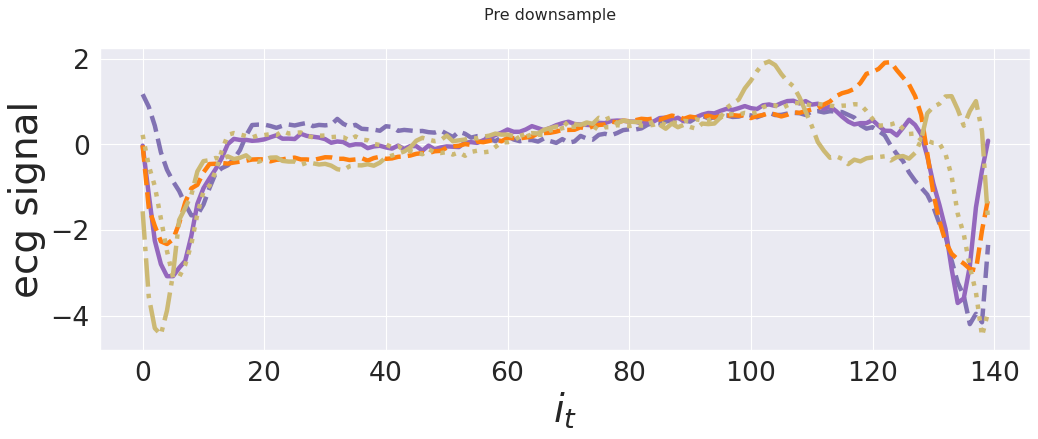

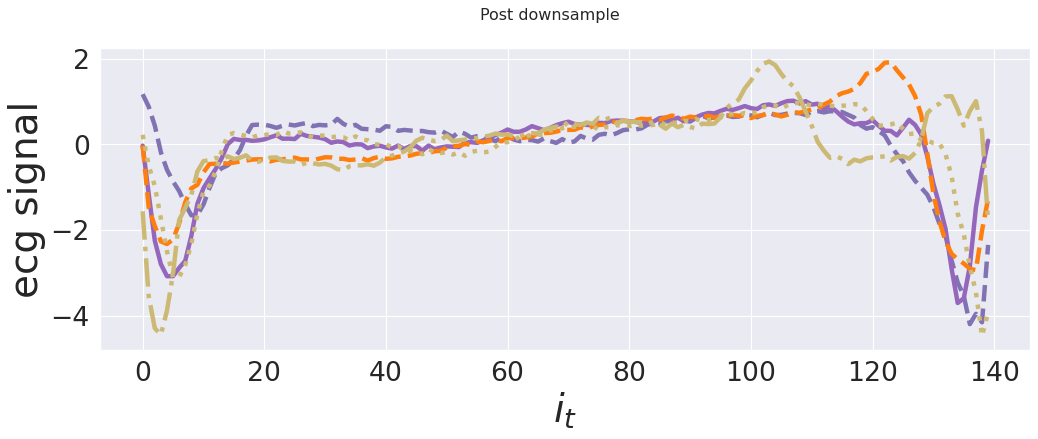

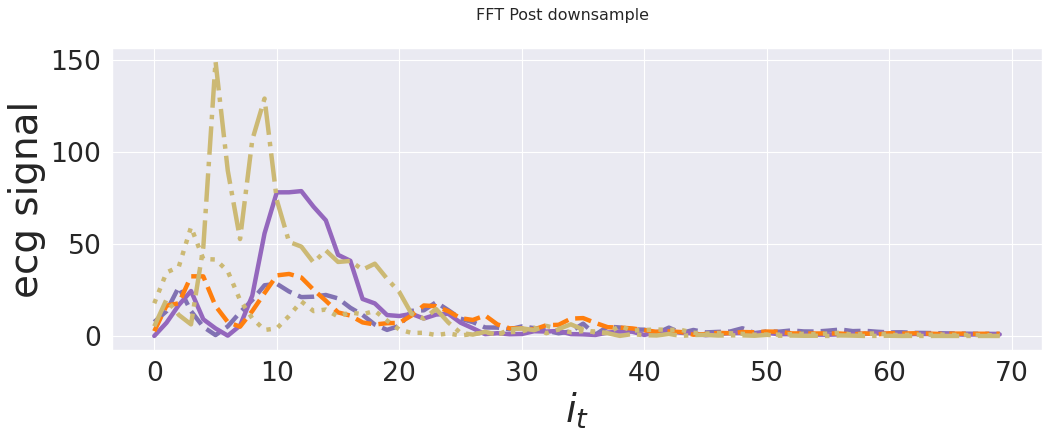

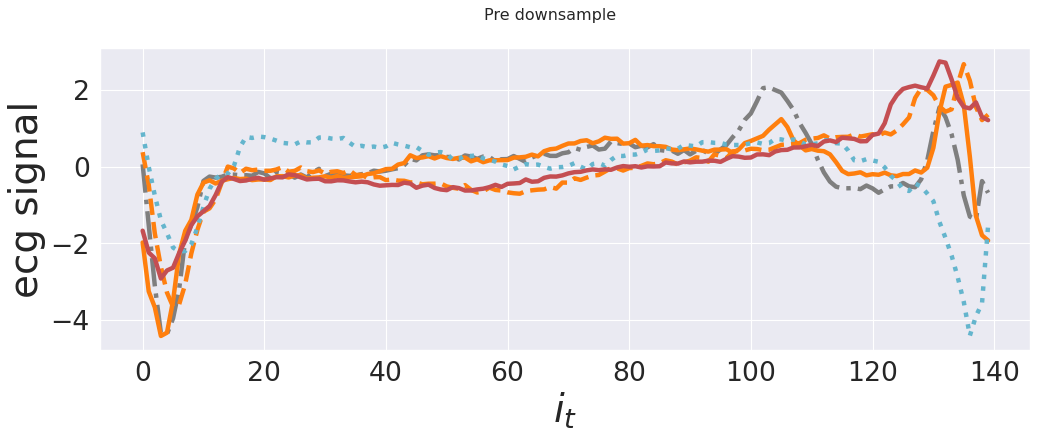

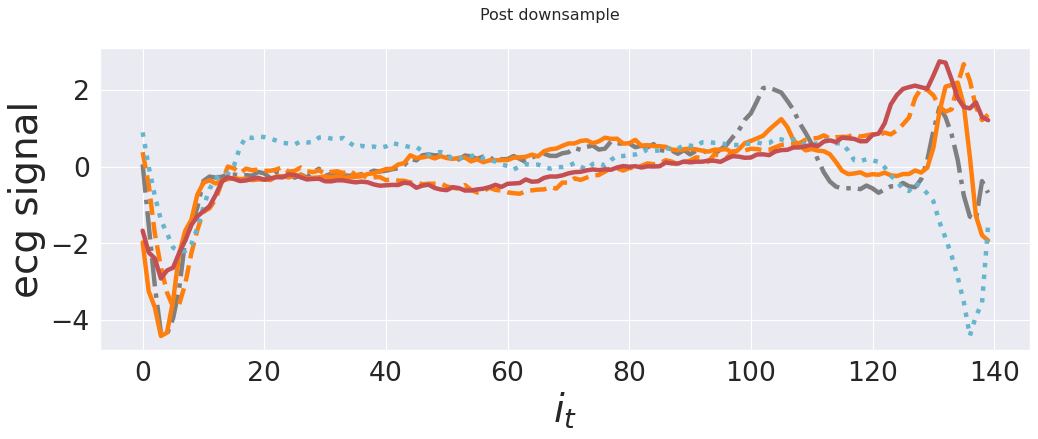

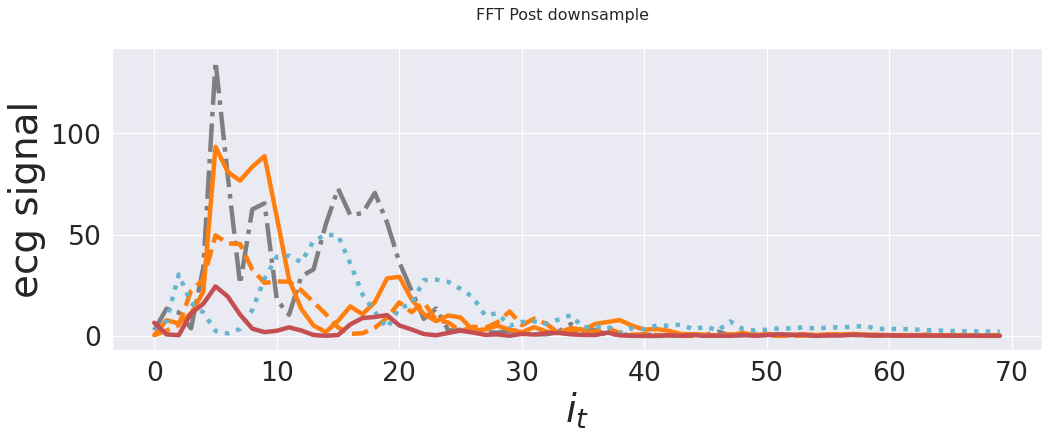

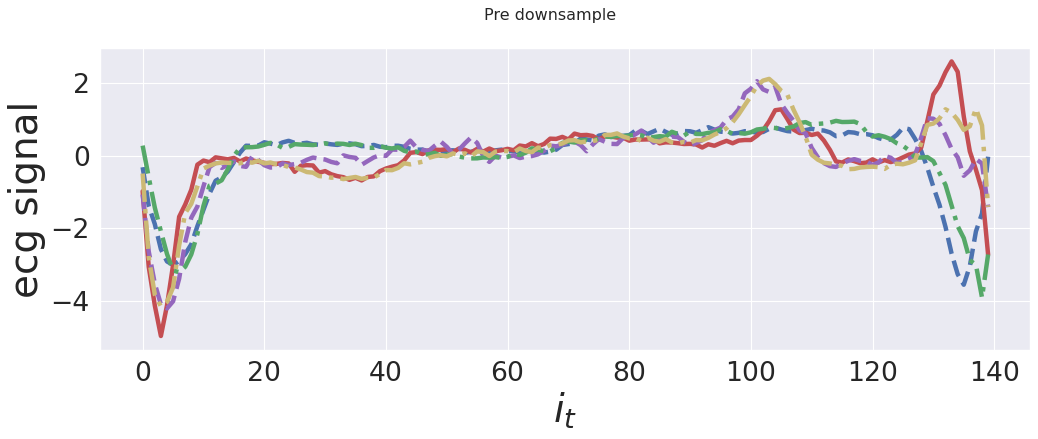

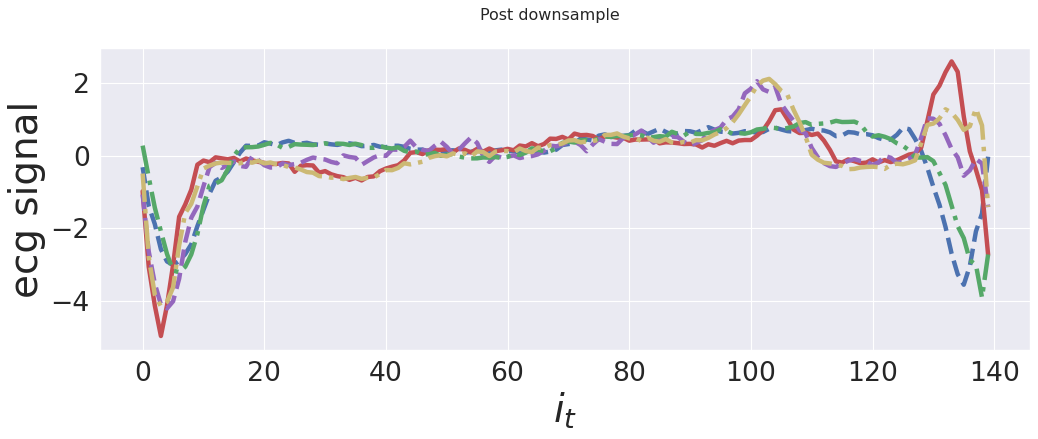

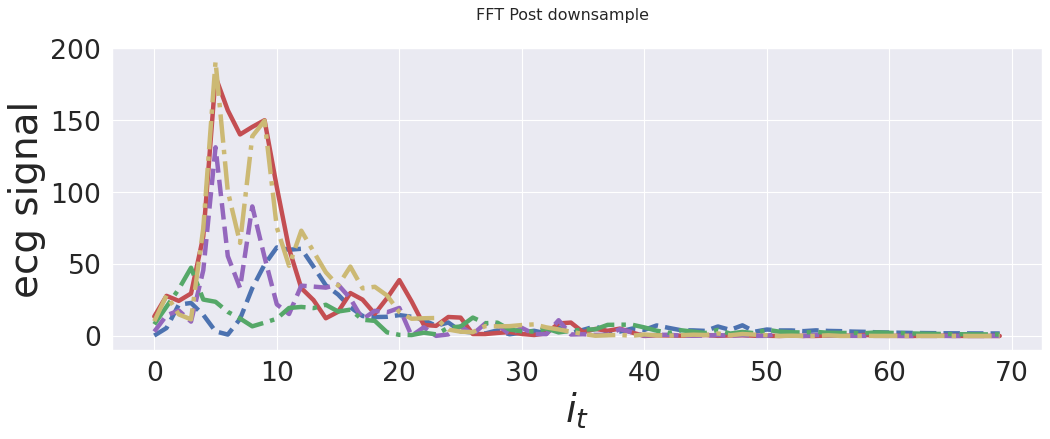

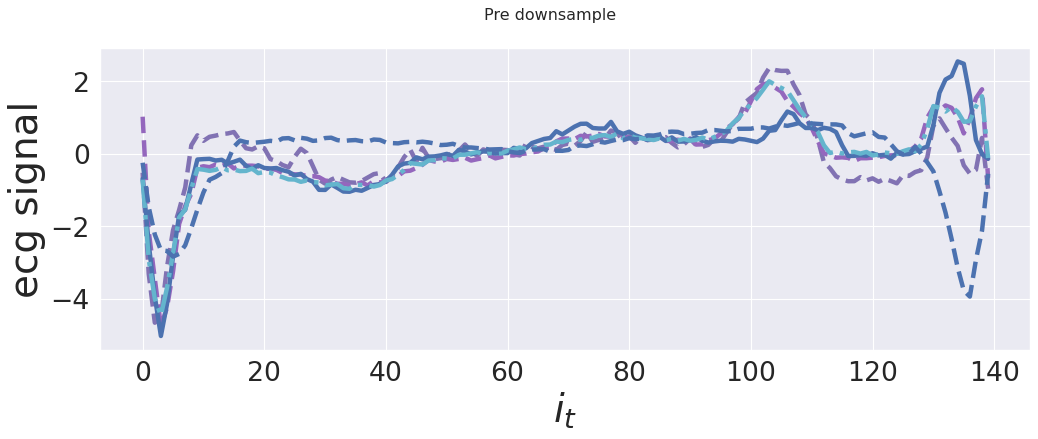

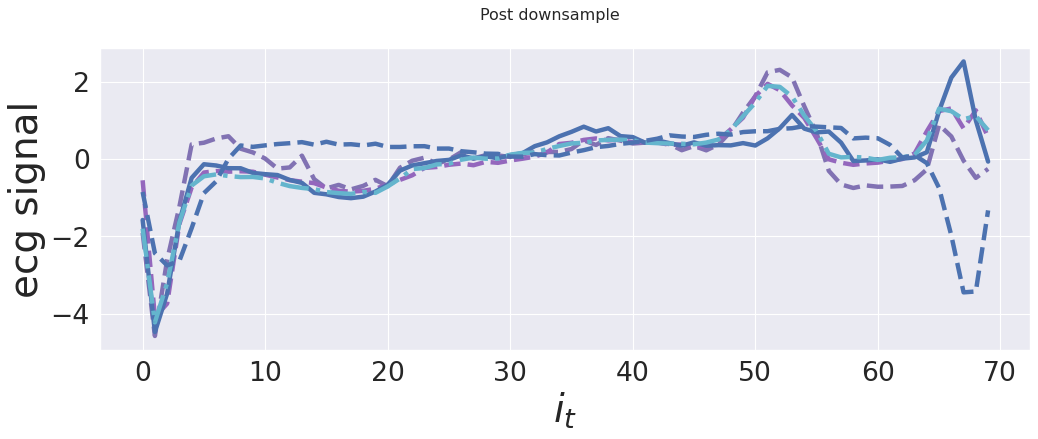

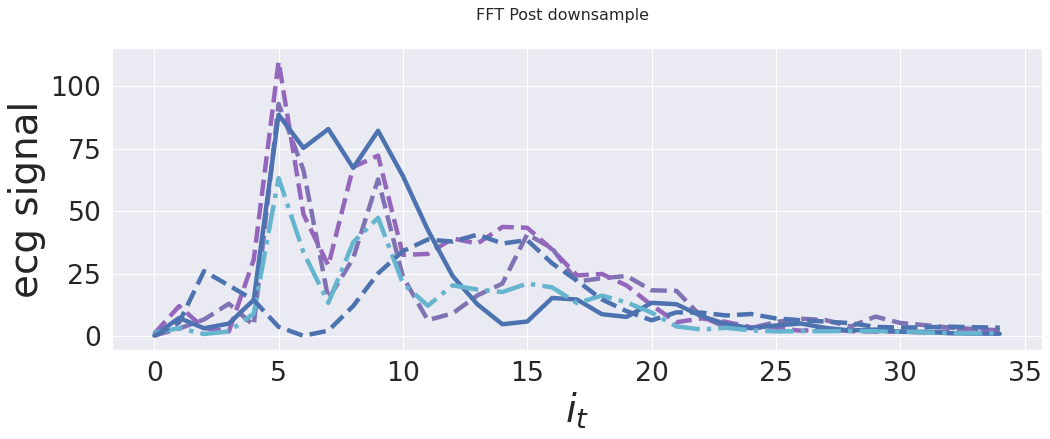

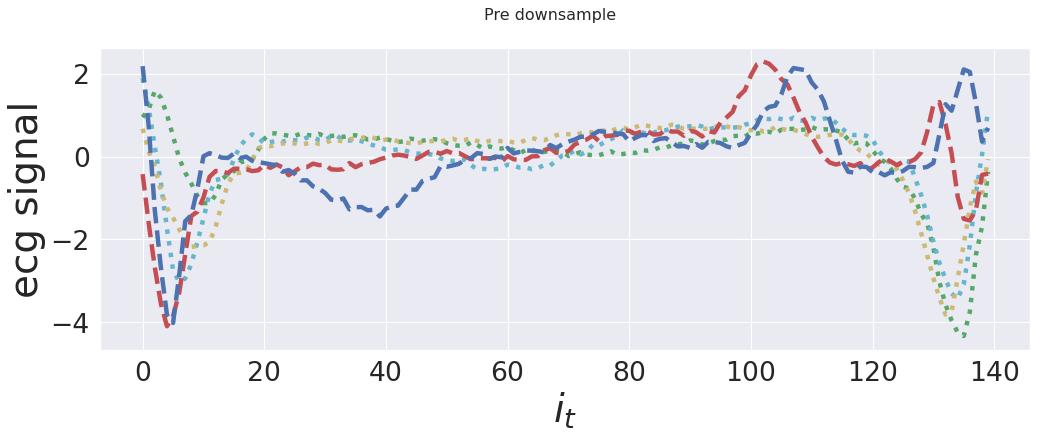

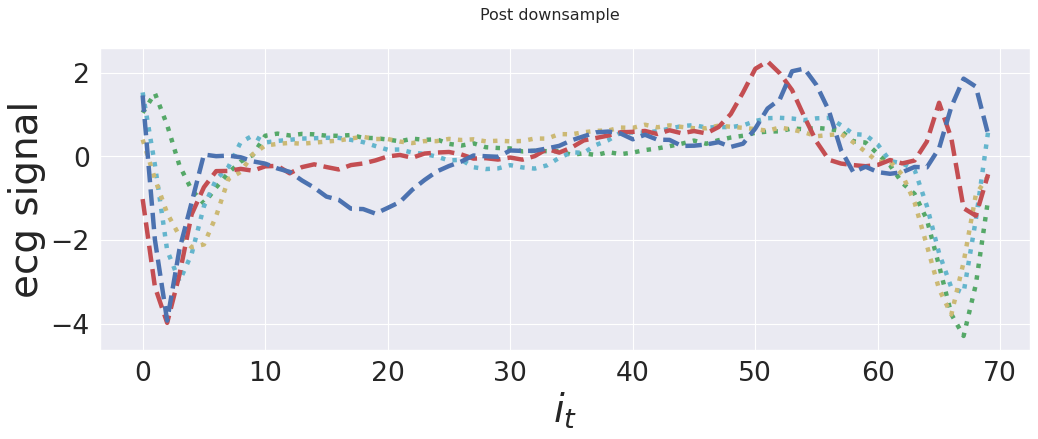

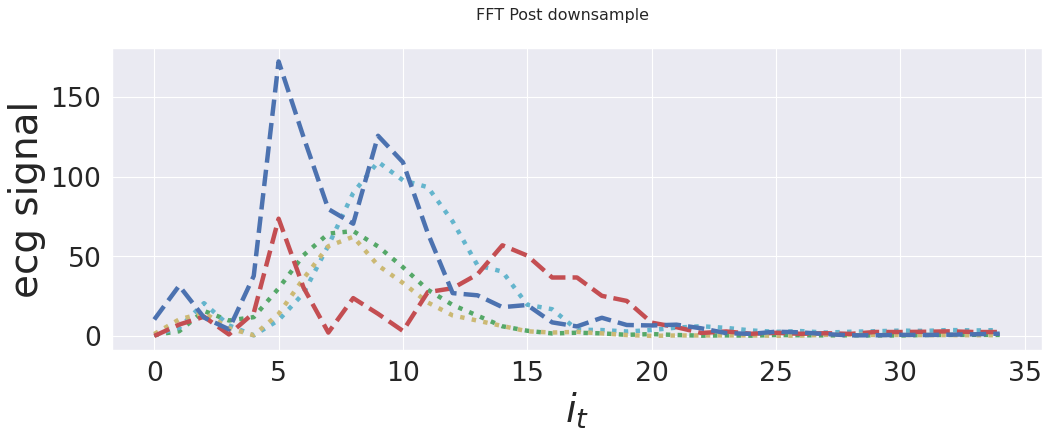

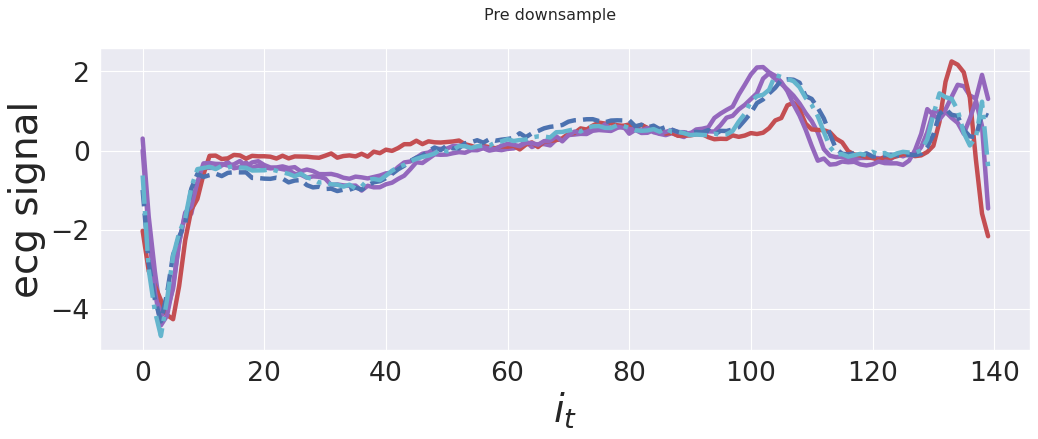

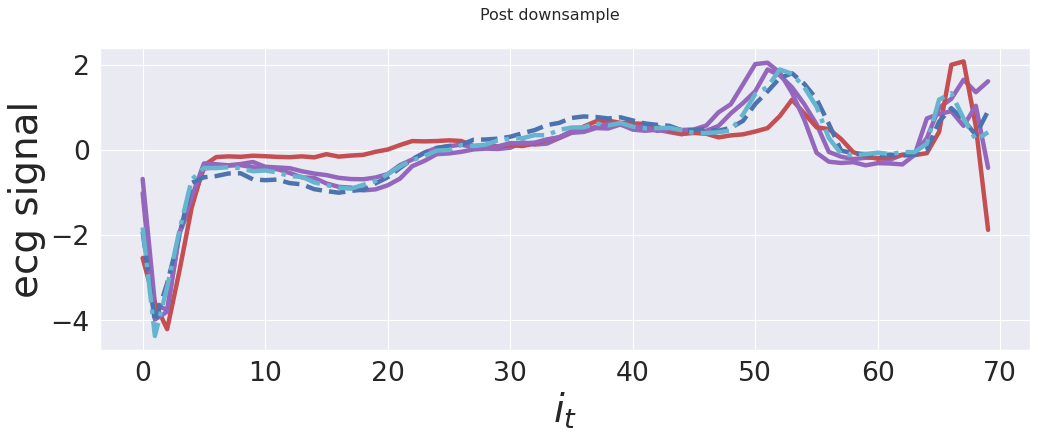

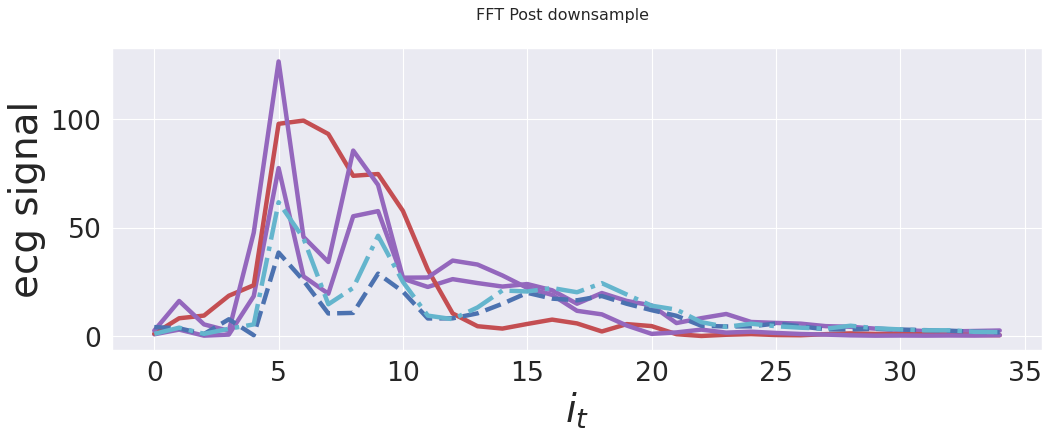

In [7]:
class TimeSeriesBundle():
    def __init__(self,name,TrainTSfile,ValTSfile,TestTSfile,downsample=1,augment=None,diff=0,RenormRows=False):

        self.name=name
        self.TrainTSfile=TrainTSfile
        self.ValTSfile=ValTSfile
        self.TestTSfile=TestTSfile
        #self.sizetuple=sizetuple
        self.downsample=downsample
        self.augment=augment
        self.diff=diff
        self.RenormRows=RenormRows
        print(" ---------- Train -------------------- ")
        self.Train=featured_tseries_df(self.TrainTSfile,downsample=self.downsample,timeft=True,freqft=True,\
                     renormMx=1.0,renormMn=0.0,augment=self.augment,diff=diff,\
                    renormRowsDct=None,selfRenorm=False)  
        print(" ---------- Val -------------------- ")
        self.Val=featured_tseries_df(self.ValTSfile,downsample=self.downsample,timeft=True,freqft=True,\
                     renormMx=1.0,renormMn=0.0,augment=self.augment,diff=diff,\
                            renormRowsDct=None)
        print(" ---------- Test -------------------- ")
        self.Test=featured_tseries_df(self.TestTSfile,downsample=self.downsample,timeft=True,freqft=True,\
                     renormMx=1.0,renormMn=0.0,augment=self.augment,diff=diff,\
                    renormRowsDct=None)
        #featured_tseries_df()
        ### se levanta el set full, con sus labels 

TSdsp1=TimeSeriesBundle("TSdsp1","../DatosOriginales/train_ecg.csv",\
        "../DatosOriginales/val_ecg.csv","../DatosOriginales/test_ecg.csv",\
            downsample=1,augment=1,diff=0)
TSdsp2=TimeSeriesBundle("TSdsp2","../DatosOriginales/train_ecg.csv",\
     "../DatosOriginales/val_ecg.csv","../DatosOriginales/test_ecg.csv",\
            downsample=2,augment=1,diff=0)
#TSdsp4=TimeSeriesBundle("TSdsp4","../DatosOriginales/train_ecg.csv",\
#        "../DatosOriginales/val_ecg.csv","../DatosOriginales/test_ecg.csv",\
#            downsample=4,augment=1,diff=0)
#TSdsp8=TimeSeriesBundle("TSdsp8","../DatosOriginales/train_ecg.csv",\
#            "../DatosOriginales/val_ecg.csv","../DatosOriginales/test_ecg.csv",\
#            downsample=8,augment=1,diff=0)
#TSdsp16=TimeSeriesBundle("TSdsp16","../DatosOriginales/train_ecg.csv",\
#        "../DatosOriginales/val_ecg.csv","../DatosOriginales/test_ecg.csv",\
#            downsample=16,augment=1,diff=0)



In [8]:
import os
import subprocess as sbp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


from scipy.stats import ttest_rel  
import scipy.stats as sta
import matplotlib.cm as cm
import matplotlib as mpl
#import matplotlib.pyplot as plt


##plots tipo slider 
import plotly.graph_objects as go


from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import PredefinedSplit
from sklearn.compose import make_column_transformer


class StandardDF_manual():
    def __init__(self,dfname,X_train,y_train,X_val,y_val,X_test,y_test,applyOHEy=False,\
                 skipcolsLs=None,applyscaler="colscaler",Xcols=None,concatTrainVal=False):
    
        #if skipcolsLs is None:
        
        self.Xcols=Xcols
  
        self.skipcolsLs=skipcolsLs
        self.X_train=X_train
        self.X_test=X_test
        self.X_val=X_val
        print(self.X_train.head())
        if skipcolsLs is not None:
            self.X_train=self.X_train.drop(columns=skipcolsLs)
            self.X_test=self.X_test.drop(columns=skipcolsLs) #, axis=1, inplace=True)
            self.X_val=self.X_val.drop(columns=skipcolsLs)#, #axis=1, inplace=True)
            self.Xcols=list(self.X_train.columns)
            print("Xcols post drop: ",self.Xcols)
            
        self.y_train=y_train
        self.y_val=y_val
        self.y_test=y_test
                
        if concatTrainVal==True:
            self.make_sklearnTrainValIndexTuple() 
            self.X_trainval=np.concatenate((self.X_train,self.X_val),axis=0)
            self.y_trainval=np.concatenate((self.y_train,self.y_val),axis=0)
            
        ##################################
        
        ############ scaling ##############
        self.applyscaler=applyscaler
        #self.Xcols=Xcols
        #if skipcolsLs is not None:# self.skipcolsLs:
        #    self.Xcols=self.Xcols-self.skipcolsLs
        
        if self.applyscaler=="colscaler":
            if Xcols is not None:
                self.X_train = pd.DataFrame(self.X_train, columns = self.Xcols)#.drop(columns=self.skipcolsLs)
                self.X_val = pd.DataFrame(self.X_val, columns = self.Xcols)#.drop(columns=self.skipcolsLs)
                self.X_test = pd.DataFrame(self.X_test, columns = self.Xcols)#.drop(columns=self.skipcolsLs)
                print( "Columns post scaler", list(self.X_train.columns) )
            else:
                print("Need Xcols to proceed with standard scaler")
            #X_train
            
            
            self.apply_scaler()
            
            
        elif self.applyscaler=="rowscaler":
            self.apply_rowscaler()
               
        self.make_sklearnTrainValIndexTuple()
        ############ balancing ############
        
        
    def make_sklearnTrainValIndexTuple(self):
        nrow_train=np.shape( self.X_train)[0]
        nrow_val=np.shape( self.X_val)[0]
        self.SKL_TrainValSplit=[-1]*nrow_train+ [0]*nrow_val
        
        self.ps = PredefinedSplit(self.SKL_TrainValSplit)
        self.ps.get_n_splits()
        
        #(np.arange(nrow_train) , \
        #       np.arange(nrow_train,nrow_train+nrow_val))
            
    def apply_rowscaler(self):
        ###################################
        self.sigmas=np.std( self.X_train ,axis=0)
        self.sigma=np.std(self.sigmas)
        self.means=np.mean(self.X_train,axis=0)
        self.mean=np.mean(self.means)
        ##################################
        self.X_train=self.X_train-self.mean###self.means[np.newaxis,:]
        self.X_train=self.X_train/self.sigma
        self.X_val=self.X_val-self.mean###self.means[np.newaxis,:]
        self.X_val=self.X_val/self.sigma
        self.X_test=self.X_test-self.mean###self.means[np.newaxis,:]
        self.X_test=self.X_test/self.sigma
        ############ subsampling #######################
        ## subsampling can be remade if necessary
        #self.make_subsample(self.SubsampFact)
        
        #print(self.X.describe())
        #print(self.y.describe())
    def apply_scaler(self):        
        trafo=make_column_transformer( (StandardScaler(),self.Xcols ))
        scaledTrain=trafo.fit_transform(self.X_train)
        scaledTest=trafo.transform(self.X_test)
        scaledVal=trafo.transform(self.X_val)
        self.X_train = pd.DataFrame(scaledTrain, columns = self.Xcols)
        self.X_val = pd.DataFrame(scaledVal, columns = self.Xcols)
        self.X_test = pd.DataFrame(scaledTest, columns = self.Xcols)
        #return scaledXmat

In [9]:
DF01=StandardDF_manual("DF01",TSdsp1.Train.df2,TSdsp1.Train.labelvec,\
                       TSdsp1.Val.df2,TSdsp1.Val.labelvec,\
                       TSdsp1.Test.df2,TSdsp1.Test.labelvec,\
                 skipcolsLs=["labelvec"],applyscaler="None",Xcols=TSdsp1.Train.df2Cols ,concatTrainVal=True)

#["amplitude","fou_maxamp"]

DF02=StandardDF_manual("DF02",TSdsp2.Train.df2,TSdsp2.Train.labelvec,\
                       TSdsp2.Val.df2,TSdsp2.Val.labelvec,\
                       TSdsp2.Test.df2,TSdsp2.Test.labelvec,\
                 skipcolsLs=["labelvec"],applyscaler="None",Xcols=TSdsp2.Train.df2Cols ,concatTrainVal=True)

#StandardDF_manual("DF16",X_train,y_train,X_val,y_val,X_test,y_test,\
 #                skipcolsLs=None,applyscaler="rowscaler")
DFLs=[DF02]

    totarea  first_der  amplitude  fou_maxamp  fou_freqmax  labelvec
0  0.644231   0.130944   5.117421    1.594845     0.214286         0
1  0.696715   0.196770   6.614420    2.097730     0.071429         1
2  0.676950   0.122527   4.553730    1.656757     0.185714         0
3  0.720035   0.156946   6.435850    1.987945     0.128571         1
4  0.660660   0.129731   5.286641    1.609720     0.171429         0
Xcols post drop:  ['totarea', 'first_der', 'amplitude', 'fou_maxamp', 'fou_freqmax']
    totarea  first_der  amplitude  fou_maxamp  fou_freqmax  labelvec
0  0.636505   0.205115   4.599764    1.066166     0.371429         0
1  0.687830   0.268545   6.102633    1.705417     0.142857         1
2  0.673000   0.206523   4.302856    1.081814     0.314286         0
3  0.702809   0.225661   5.989818    1.801579     0.142857         1
4  0.653406   0.224841   4.938348    1.065217     0.342857         0
Xcols post drop:  ['totarea', 'first_der', 'amplitude', 'fou_maxamp', 'fou_freqmax']


In [10]:
DF02.X_test

totarea  first_der  amplitude  fou_maxamp  fou_freqmax
0    0.664283   0.190818   5.111013    1.071714     0.085714
1    0.686984   0.214909   4.196834    1.560433     0.257143
2    0.579126   0.227992   5.867514    1.896450     0.142857
3    0.656854   0.218963   4.788799    1.356361     0.314286
4    0.608325   0.198611   5.522284    1.946046     0.085714
..        ...        ...        ...         ...          ...
993  0.601812   0.278025   6.714374    1.498366     0.142857
994  0.655262   0.133273   4.713814    1.850734     0.085714
995  0.638595   0.201544   4.664953    1.278989     0.085714
996  0.730317   0.191092   5.830270    1.350950     0.142857
997  0.695635   0.198464   5.928734    1.865304     0.142857

[998 rows x 5 columns]

Processing :  SGD SGDClassifier()
{'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'none'}
Processing :  LOG LogisticRegression()
{'C': 0.01, 'penalty': 'none'}
Processing :  RID RidgeClassifier()
{'alpha': 0.5}
Processing :  KNN KNeighborsClassifier()
{'n_neighbors': 7, 'p': 1}
Processing :  CART DecisionTreeClassifier()
{'criterion': 'gini', 'max_depth': 5}
Processing :  SVC SVC()
{'C': 10.0, 'kernel': 'rbf'}
Processing :  LinearSVC LinearSVC()
{'C': 10.0, 'tol': 0.001}
Processing :  AB AdaBoostClassifier()
{'learning_rate': 0.1}
Processing :  GB GradientBoostingClassifier()
{'learning_rate': 0.02, 'min_samples_leaf': 50, 'min_samples_split': 50}
Processing :  RF RandomForestClassifier()
{'max_depth': 6, 'n_estimators': 150}
Processing :  ET ExtraTreesClassifier()
{'max_depth': 6, 'n_estimators': 50}
Processing :  MLP MLPClassifier()
{'activation': 'relu', 'alpha': 1.5, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': 3.0, 'solver': 'lbfgs'}
Proce

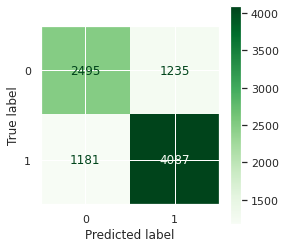

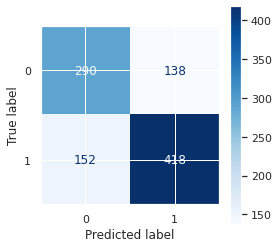

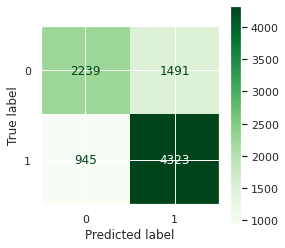

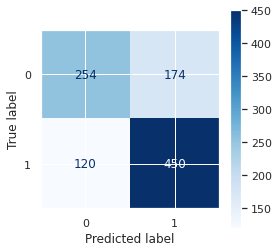

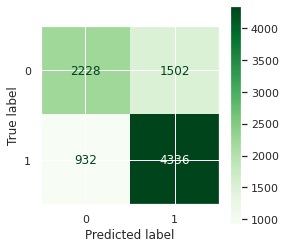

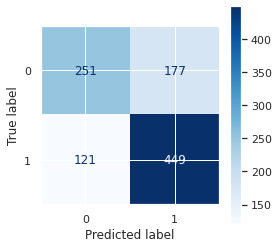

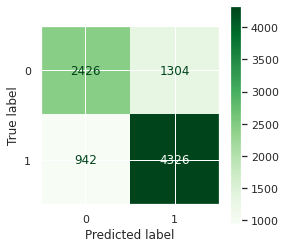

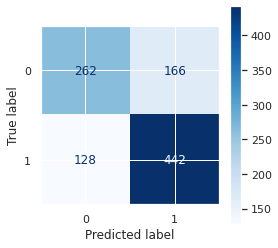

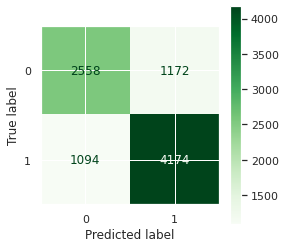

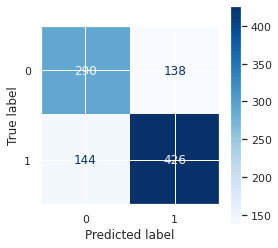

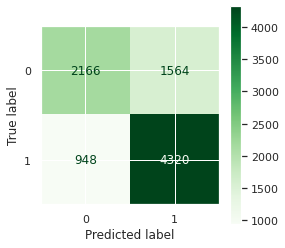

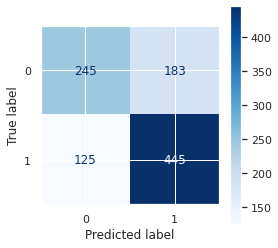

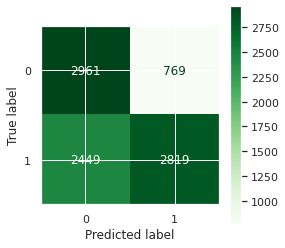

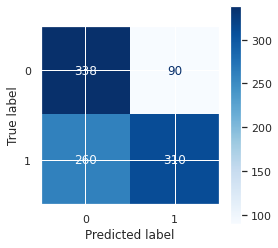

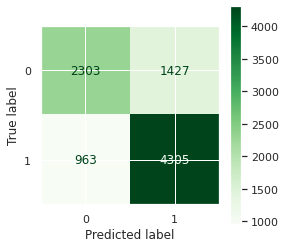

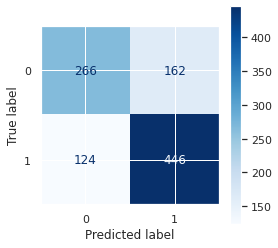

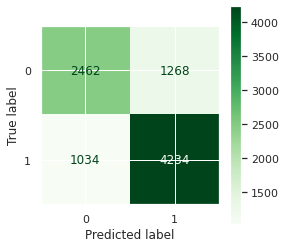

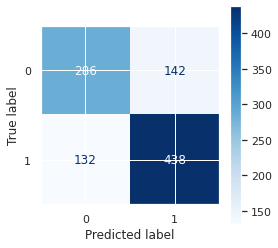

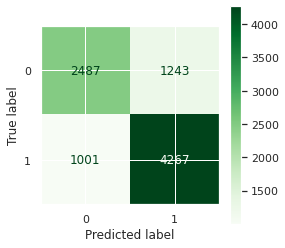

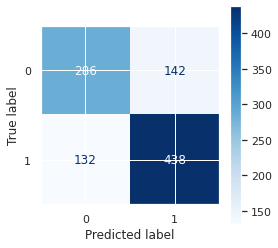

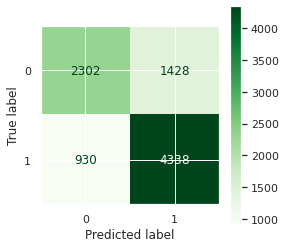

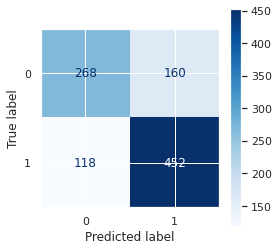

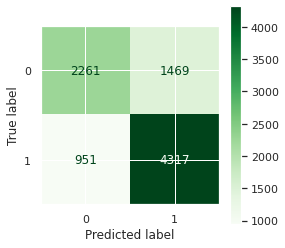

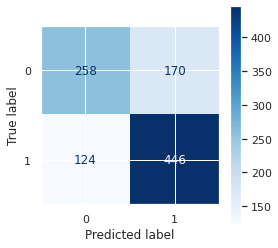

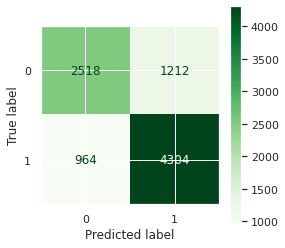

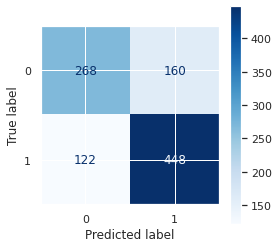

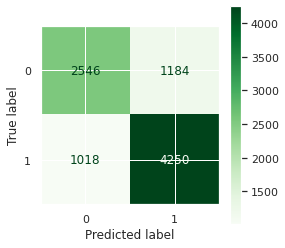

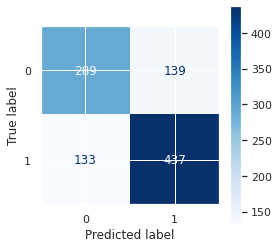

In [11]:
import warnings
warnings.filterwarnings('ignore')
from joblib import parallel_backend

from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

###Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.tree import DecisionTreeClassifier

# Ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier



from sklearn.model_selection import RepeatedStratifiedKFold,\
	 train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve,\
	 roc_auc_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay
#import eli5
#from eli5.sklearn import PermutationImportance
from scipy.stats import ttest_rel  

from sklearn.model_selection import ParameterGrid
#from sklearn.metrics import r2_score
import sklearn.metrics as met


#from pandas_ml import ConfusionMatrix


import time
from matplotlib import pyplot


scoringDct = {"accuracy_score":"pred","roc_auc_score":"prob","roc_curve":"prob","precision_score":"pred",\
                "recall_score":"pred","confusion_matrix":"pred","precision_recall_curve":"prob"}#,"precission_recall_curve")#'neg_mean_squared_error'



pipeLs = []
sns.set(rc={"figure.figsize":(4, 4)})
ModelDct={
    "SGD":SGDClassifier() ,\
            "LOG": LogisticRegression(),\
        "RID":RidgeClassifier(),\
        "KNN":KNeighborsClassifier(),\
        "CART":DecisionTreeClassifier() ,\
          "SVC":SVC(),\
         "LinearSVC": LinearSVC(), \
         "AB":AdaBoostClassifier( ), \
    "GB":GradientBoostingClassifier() ,\
         "RF":RandomForestClassifier() ,\
        "ET":ExtraTreesClassifier()  ,\
         "MLP": MLPClassifier(), \
        "BAG":BaggingClassifier(KNeighborsClassifier()),\
       #"XGB":XGBClassifier(),\
    "LGB":LGBMClassifier(),\
}


GridDct={
         "SGD":{"penalty":["l2", "none"],"alpha":[0.0001,0.001,0.01],"loss":["modified_huber"]},
    "LOG":{"penalty":["l2", "none"],"C":[0.01,0.1,1.0]} ,\
         "RID":{"alpha":[0.5,0.75,1.0,5.0,10.0]} ,\
         "KNN":{"n_neighbors":[5,6,7,9],"p":[1,2]}, \
         "CART":{"criterion":["gini","entropy"],"max_depth":[2,5,6,10]} ,\
         "SVC":{"C":[0.1,1.0,10.0],"kernel":["poly","rbf"]},\
         "LinearSVC": {"C":[0.01,0.1,1.0,10.0],"tol":[0.001]}, \
         "AB":{"learning_rate":[0.1,0.5,1.0]},\
            "GB":{"learning_rate":[0.02,0.03],\
               "min_samples_split":[50],"min_samples_leaf":[50]} ,\
         "RF":{"n_estimators":[50,100,150],"max_depth":[2,5,6]} ,\
        "ET": {"n_estimators":[50,100,150],"max_depth":[2,5,6]} ,\
         "MLP":{"hidden_layer_sizes":[(50,),(25,25,)],"activation":["relu"],\
                "alpha":[1.5],"learning_rate":["adaptive"],\
                "learning_rate_init":[0.01,0.1,1.0,3.0],"solver":["lbfgs"]},\
          "BAG":{"bootstrap":[True,False],"max_features":[2,4,8],"n_estimators":[10,20]},\
    "LGB":{"boosting_type":["gbdt","dart","rf"]},\
  #  "XGB":{"learning_rate":[0.01,0.05,0.1,1.0,3.0],"max_depth":[4,5,6]}\              
}

names=[]
PredDict={}
timings={}

#We gather the scorings from each method.
CVResu={}
BigChartTra={"names":[],"time":[],"ngrid":[],"confmat":[],"plots_confmat":[],"feat_imp":[]}
BigChartTe={"names":[],"time":[],"ngrid":[],"confmat":[],"plots_confmat":[],"feat_imp":[]}
BestParsDct={}

for key in scoringDct.keys():
    BigChartTra[key]=[]#
    BigChartTe[key]=[]#

#YpredTest=
YpredTrain={}
YpredTest={}

## Option to run the computationally intensive methods from the dict:
HeavyCatalog=["SVC","MLP","LinearSVC"]
runheavy=True


# More complex function, that tries to generate the probability or scoring.            
def make_scoring2(CollectDct,model,scoreDct,Xint,ytrue,cla_reg="cla"):
    import sklearn.metrics as met
    functions_to_try=["predict","predict_proba","decision_function"]
    if cla_reg=="cla":
        ### 
        modelPreScorers={}
        for funtry in functions_to_try:
            xsco=Xint
            if hasattr(model, funtry):
                ysco=getattr(model,funtry)(xsco)                            
            else:
                continue                
            if funtry=="predict_proba":
                modelPreScorers[funtry]= ysco[:,1]  
            else :
                modelPreScorers[funtry]= ysco  
        
        
        for sco,prob_pred in scoreDct.items(): #
            if prob_pred=="pred":
                yscofun=modelPreScorers["predict"]
                if hasattr(met,sco):
                    CollectDct[sco].append( getattr(met,sco)(ytrue,yscofun) )
                else :
                    CollectDct[sco].append( np.nan )
            
            if prob_pred=="prob":
                for funtry in functions_to_try[1:]:
                    if hasattr(model, funtry):
                        yscofun=modelPreScorers[funtry]
                        CollectDct[sco].append( getattr(met,sco)(ytrue,yscofun) )
                        break
                    #if hasattr(met,sco):
                    
                    
            
def dct_to_string(dct):
    str0=""
    for key,val in dct.items():
        str0=str(key)+" : "+str(val)+" ; "
    return str0
num_folds = 10
seed = 203
### Utilizamos la libreria joblib, que permite paralelizar 
### internamente los procedimientos de scikit learn
for DF in DFLs:
    with parallel_backend('threading', n_jobs=8):
        #for name, model in pipeLs:
        for name, mod in ModelDct.items():


            ####
            dfObj=DF

            if runheavy==False:
                if name in HeavyCatalog:
                    continue

            ngrid=1
            for val in GridDct[name].values():
                ngrid*=len(val)

            print("Processing : ", name, mod)
            t0=time.time()
            simu=GridSearchCV( mod,GridDct[name],cv=dfObj.ps,return_train_score=True, \
                              scoring="roc_auc")

            #simu.fit(dfObj.X_tra, dfObj.y_tra)
            simu.fit(dfObj.X_trainval, dfObj.y_trainval)
            
            print(simu.best_params_)
            bestpar=dct_to_string(simu.best_params_)
            BestParsDct[name]=bestpar

            #ypre=simu.best_estimator_.predict(dfObj.X_tra)
            ypre=simu.best_estimator_.predict(dfObj.X_trainval)

            t1=time.time()
            names.append(name)

            #ypreTe=simu.best_estimator_.predict(dfObj.X_te)
            ypreTe=simu.best_estimator_.predict(dfObj.X_test)



            YpredTrain[name]=ypre
            YpredTest[name]=ypreTe
            ###############################################
            BigChartTra["names"].append(name)
            #BigChartTra["every"].append(dfObj.SubsampFact)
            BigChartTra["time"].append( t1-t0 )        
            BigChartTra["ngrid"].append(ngrid)
            #BigChartTra["plots_confmat"].append( plot_confusion_matrix(simu.best_estimator_, \
            #                    dfObj.X_tra, dfObj.y_tra,cmap="Greens") )
            
            BigChartTra["confmat"].append(  confusion_matrix(dfObj.y_trainval , ypre ) )# ConfusionMatrix(dfObj.y_trainval , ypre) )#
            BigChartTra["Accu"]=np.sum(np.diag( confusion_matrix(dfObj.y_trainval , ypre ) ))/\
                 np.sum( confusion_matrix(dfObj.y_trainval , ypre ) )
            BigChartTra["plots_confmat"].append( plot_confusion_matrix(simu.best_estimator_, \
                                dfObj.X_trainval, dfObj.y_trainval,cmap="Greens") )
            
            if hasattr(simu.best_estimator_,"feature_importances_")==True:
                BigChartTra["feat_imp"].append(simu.best_estimator_.feature_importances_)
            else:
                BigChartTra["feat_imp"].append(np.nan)
            #make_scoring(BigChartTra,scoringDct, MainDF.y_tra, ypre,ydeci,cla_reg="cla")
            #make_scoring2(BigChartTra,simu,scoringDct,dfObj.X_tra,dfObj.y_tra,cla_reg="cla")
            make_scoring2(BigChartTra,simu,scoringDct,dfObj.X_trainval,dfObj.y_trainval,cla_reg="cla")
            ################################################
            BigChartTe["names"].append(name)
            #BigChartTe["every"].append(dfObj.SubsampFact)
            BigChartTe["time"].append( t1-t0 )
            BigChartTe["ngrid"].append(ngrid)
            
            BigChartTe["confmat"].append(confusion_matrix(dfObj.y_test , ypreTe ) )# ConfusionMatrix(dfObj.y_test , ypreTe) )#pd.crosstab(ypreTe, dfObj.y_test ).to_numpy() )
            BigChartTe["Accu"]=np.sum(np.diag( confusion_matrix(dfObj.y_test , ypreTe ) ))/\
                 np.sum( confusion_matrix(dfObj.y_test , ypreTe ) )
            BigChartTe["plots_confmat"].append( plot_confusion_matrix(simu.best_estimator_, dfObj.X_test,\
                                            dfObj.y_test,cmap="Blues") )
            if hasattr(simu.best_estimator_,"feature_importances_")==True:
                BigChartTe["feat_imp"].append(simu.best_estimator_.feature_importances_)
            else:
                BigChartTe["feat_imp"].append(np.nan)
            #make_scoring(BigChartTe,scoringDct, MainDF.y_te, ypreTe,ydeciTe,cla_reg="cla")
            make_scoring2(BigChartTe,simu,scoringDct,dfObj.X_test,dfObj.y_test,cla_reg="cla")
            #################################################
            
            CVResu[name]=simu.cv_results_# ); CVResu["names"].append(name)
            
            #################################################

TRAINING
TESTING


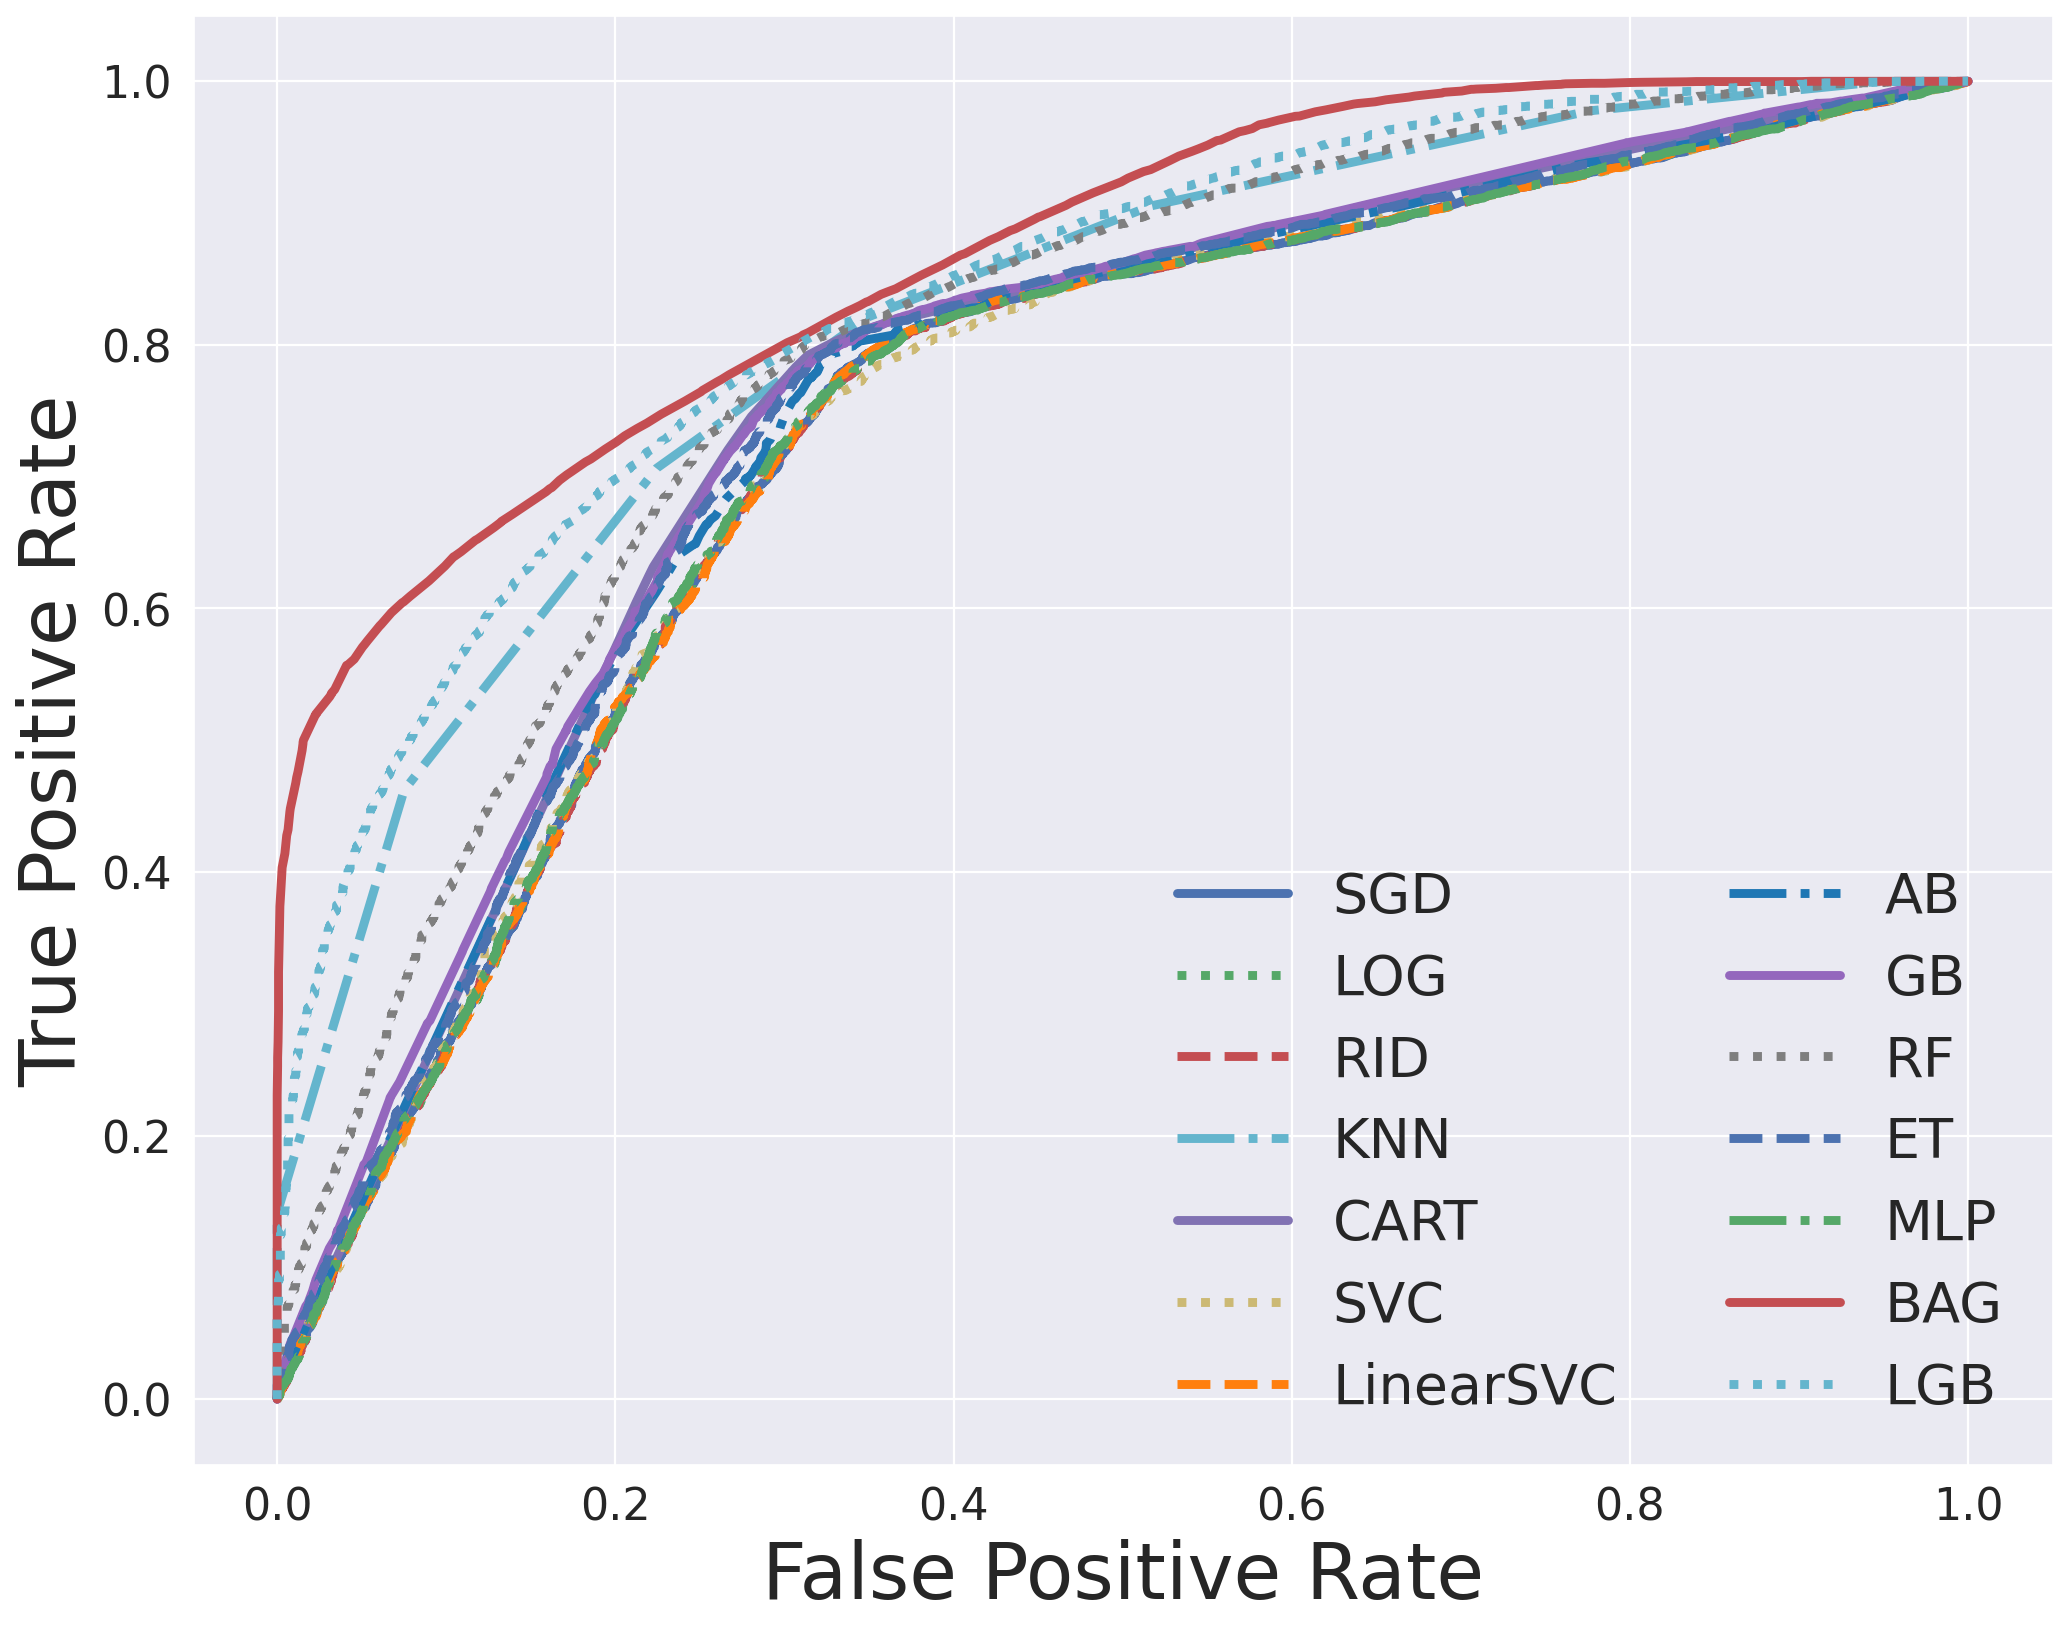

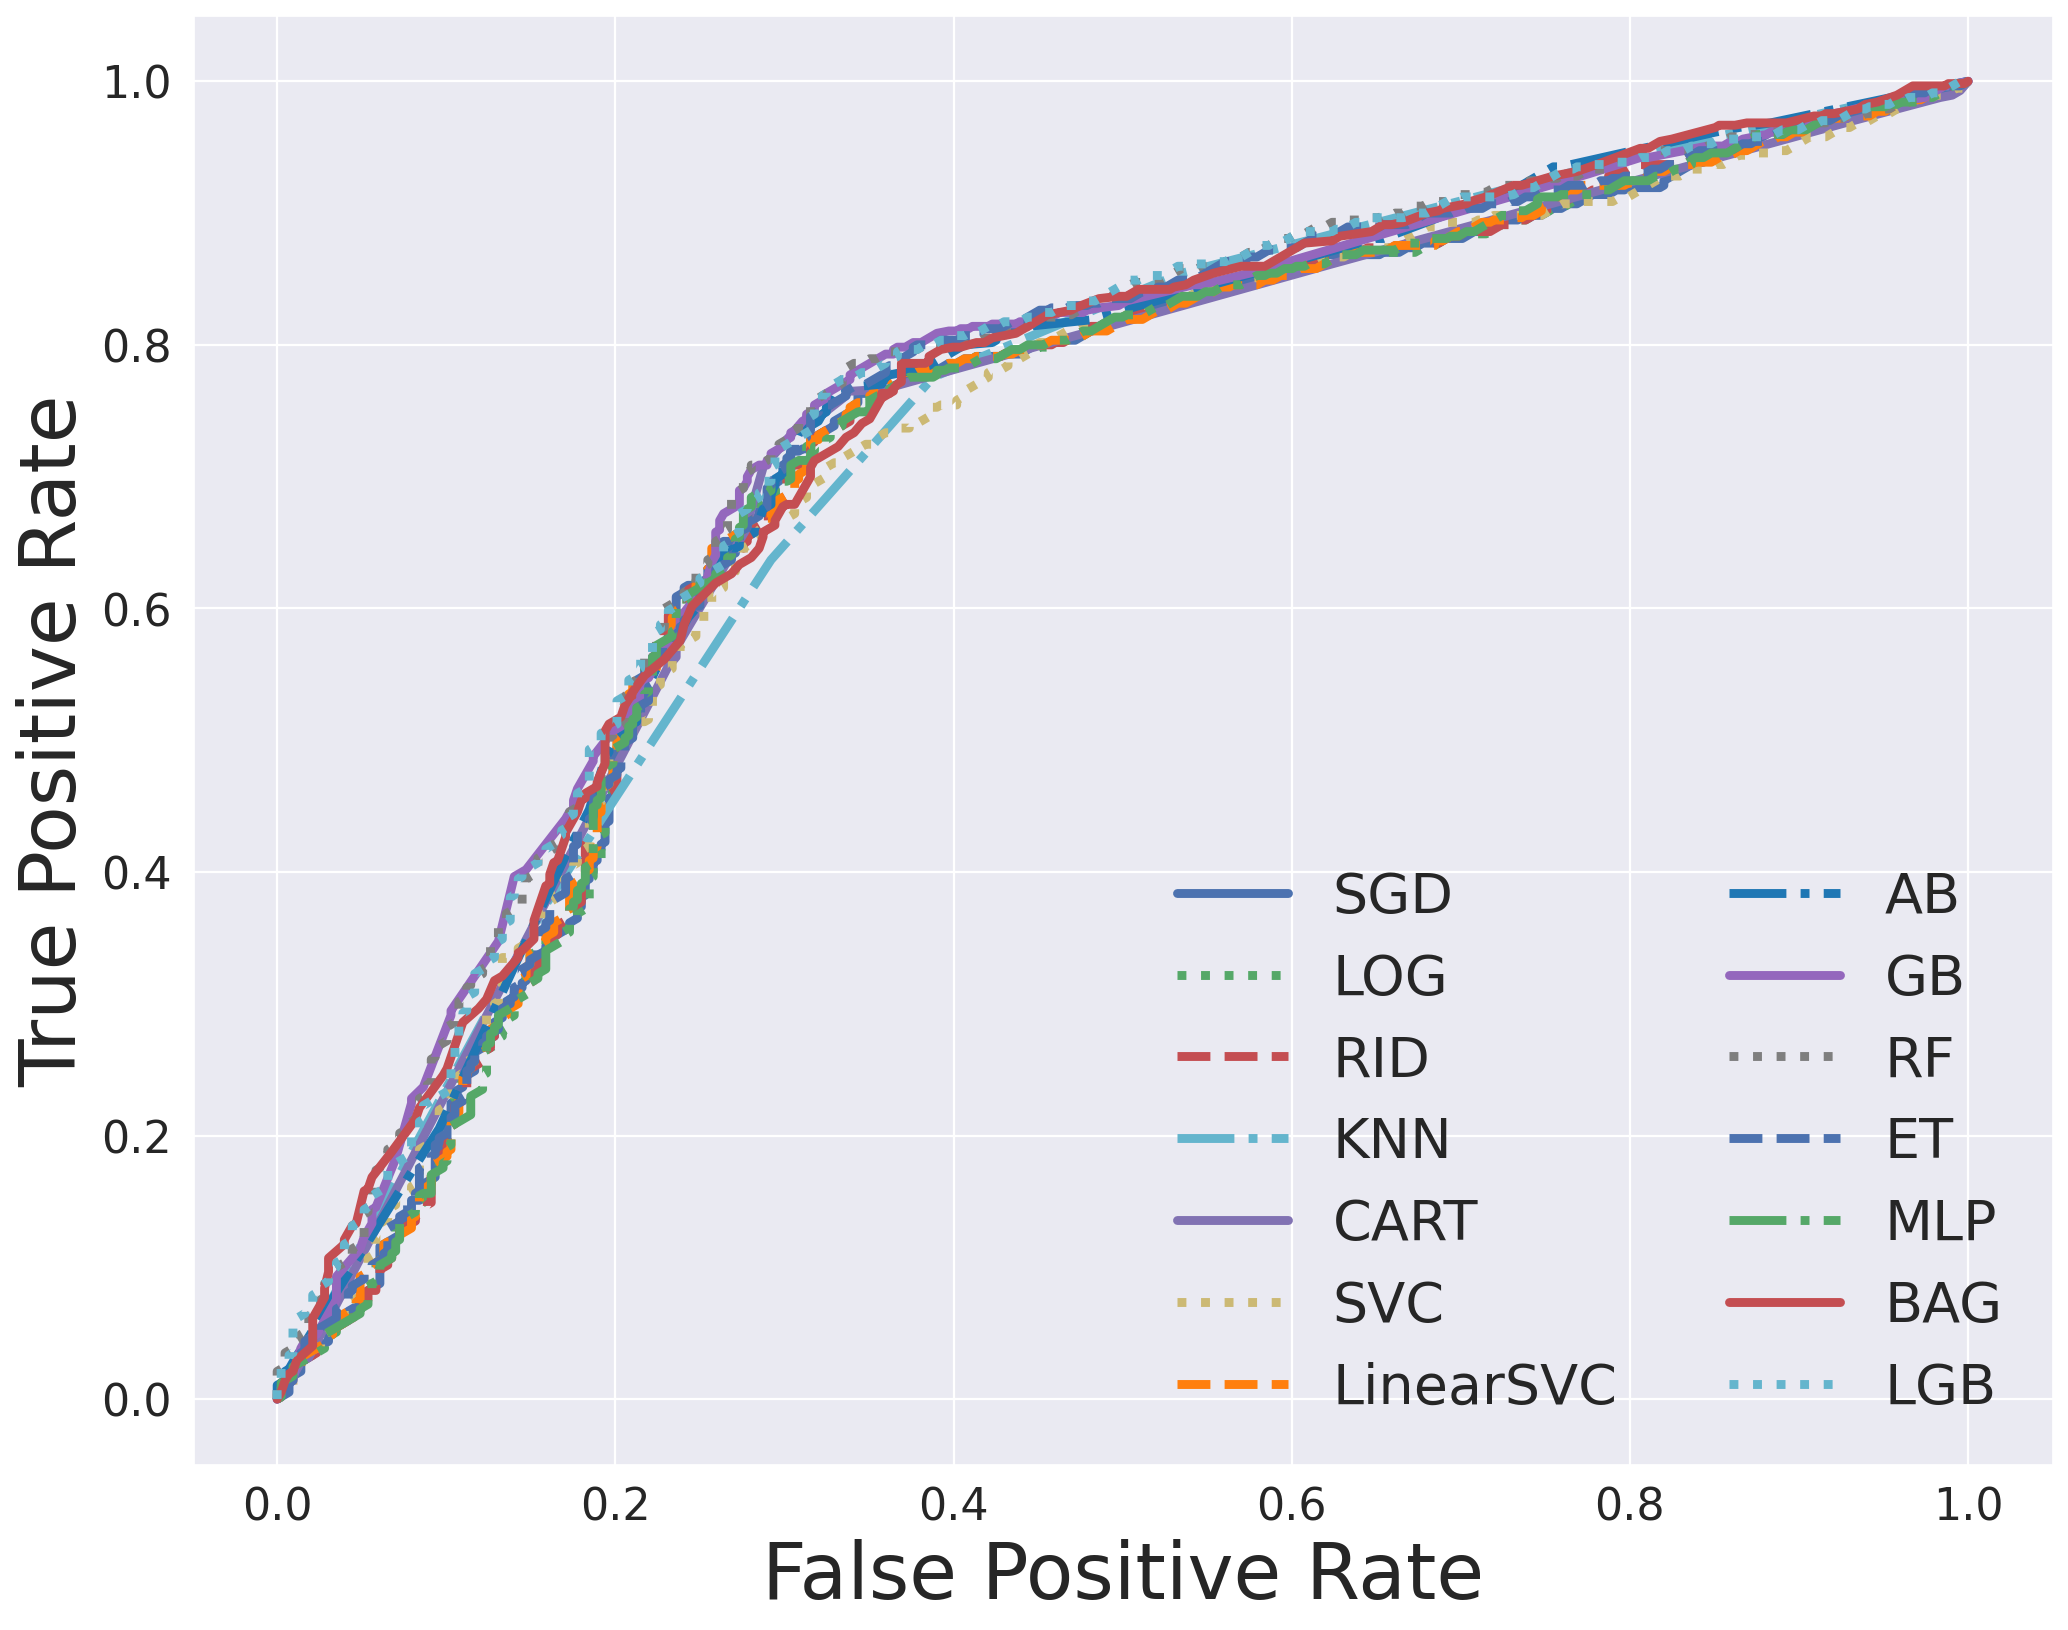

names  roc_auc_score  ngrid
9          RF       0.737629      9
13        LGB       0.736621      3
8          GB       0.733624      2
12        BAG       0.728562     12
7          AB       0.724922      3
10         ET       0.722151      9
3         KNN       0.717154      8
4        CART       0.715687      8
6   LinearSVC       0.712018      4
0         SGD       0.711313      6
2         RID       0.711059      5
1         LOG       0.710985      6
11        MLP       0.710887      8
5         SVC       0.708477      6

names  time_per_run  ngrid
5         SVC      2.068087      6
11        MLP      1.298448      8
8          GB      0.753945      2
9          RF      0.287678      9
13        LGB      0.203467      3
7          AB      0.189880      3
10         ET      0.176076      9
12        BAG      0.167611     12
6   LinearSVC      0.116074      4
1         LOG      0.070690      6
3         KNN      0.043622      8
0         SGD      0.033130      6
4        CART      0.015022      8
2         RID      0.007087      5

names  ngrid  roc_auc_score  roc_auc_score_Te  overfit_rating  \
9          RF      9       0.795093          0.737629        0.765284   
13        LGB      3       0.834287          0.736621        0.782418   
8          GB      2       0.763294          0.733624        0.748165   
12        BAG     12       0.865960          0.728562        0.791341   
7          AB      3       0.752426          0.724922        0.738418   
10         ET      9       0.755834          0.722151        0.738609   
3         KNN      8       0.815922          0.717154        0.763357   
4        CART      8       0.758476          0.715687        0.736461   
6   LinearSVC      4       0.739803          0.712018        0.725645   
0         SGD      6       0.740204          0.711313        0.725471   
2         RID      5       0.739641          0.711059        0.725069   
1         LOG      6       0.740234          0.710985        0.725315   
11        MLP      8       0.740815          0.710887        0.725543   
5         SVC      6       0.740481          0.708477        0.724125   

    overfit_rating2  
9          0.074983  
13         0.124344  
8          0.039641  
12         0.172338  
7          0.037234  
10         0.045579  
3          0.128849  
4          0.058053  
6          0.038276  
0          0.039807  
2          0.039405  
1          0.040308  
11         0.041232  
5          0.044175

names      Accu
0         SGD  0.727455
1         LOG  0.727455
2         RID  0.727455
3         KNN  0.727455
4        CART  0.727455
5         SVC  0.727455
6   LinearSVC  0.727455
7          AB  0.727455
8          GB  0.727455
9          RF  0.727455
10         ET  0.727455
11        MLP  0.727455
12        BAG  0.727455
13        LGB  0.727455

In [13]:

from IPython.display import display

DFTra=pd.DataFrame(BigChartTra)
DFTe=pd.DataFrame(BigChartTe)
DFTra["time_per_run"]=DFTra["time"]/DFTra["ngrid"]
DFTe["time_per_run"]=DFTe["time"]/DFTe["ngrid"]

print("TRAINING")
#display(DFTra)
print("TESTING")
#display(DFTe)



def show_roc(DF):
    
    linestyle_str = ["-",":","--","-."]
    linewidth=[4]
    linecol=["b","g","r","c","m","y","tab:orange","tab:blue","tab:purple","tab:grey"]
    nwidths=len(linewidth)
    nstyles=len(linestyle_str)
    ncolor=len(linecol)
    fig = plt.figure(figsize=(15.0, 12.0), dpi=160)
    plt.clf()
    ax1 = fig.add_subplot(1,1,1)
    ax1.tick_params("both",labelsize=20)
    ax1.set_xlabel('False Positive Rate', fontsize = 35)
    ax1.set_ylabel('True Positive Rate', fontsize = 35)
    for il,line in enumerate(DF["roc_curve"]):
        #print(np.shape(line))

        #DFTe.iloc[il,"roc_curve"]
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(line[0],line[1],lw=linewidth[il%nwidths],linestyle=linestyle_str[il%nstyles],\
                 color=linecol[il%ncolor])
        #plt.savefig(strname ,bbox_inches='tight', transparent=False)
        ##fig.delaxes(ax)
        #leg1=ax1.legend(fontsize = 35,frameon=False, loc=2,ncol=2)
        leg1=ax1.legend(fontsize = 25,frameon=False, loc=0,ncol=2,labels=list(DF["names"]))
    plt.show()

def show_confmat(DF):
    #fig,ax =  plt.subplots(figsize=(15.0, 12.0), dpi=160)
    #ax1 = fig.add_subplot(1,1,1)
    for index, row in DF.iterrows():
        print(row["names"])
        row["plots_confmat"].plot()
        
        #plt.show()
        
        
show_roc(DFTra)
show_roc(DFTe)


#show_confmat(DFTra)
#show_confmat(DFTe)

##X=pd.concat([DBNum,DBFact],axis=1)
display(DFTe[["names","roc_auc_score","ngrid"]].sort_values(by="roc_auc_score",ascending=False))

display(DFTe[["names","time_per_run","ngrid"]].sort_values(by="time_per_run",ascending=False))

def overfitting_rating(aucTra,aucTe):
    rat=2.0*aucTra*aucTe/(aucTe+aucTra)
    return rat
    
DFauc=DFTra[["names","ngrid","roc_auc_score"]].copy(deep=True)
#print(DFauc.head())
DFauc=DFauc.join(DFTe["roc_auc_score"],how="left",lsuffix="",rsuffix=("_Te"))
#print(DFauc.head())
DFauc["overfit_rating"]=2.0*(DFauc["roc_auc_score"]*DFauc["roc_auc_score_Te"])/(DFauc["roc_auc_score"]+DFauc["roc_auc_score_Te"] )
DFauc["overfit_rating2"]=2.0*(DFauc["roc_auc_score"]-DFauc["roc_auc_score_Te"])/(DFauc["roc_auc_score"]+DFauc["roc_auc_score_Te"] )
display(DFauc.sort_values(by="roc_auc_score_Te",ascending=False))




display(DFTe[["names","Accu"]].sort_values(by="Accu",ascending=False))

#for name,BP in BestParsDct.items():
#    print(name,BP)


    